# Sentence Representation with Neural Models: An NLP Project

**Multi-Architecture Semantic Analysis on Stanford Sentiment Treebank (SST)**

Project Context & Methodology
This project serves as a comprehensive benchmark for evaluating neural architectures in the domain of Sentence Representation Learning. The objective is to extract high-dimensional semantic features from text to perform downstream sentiment classification.

To ensure industrial-grade standards, the project is built on two core principles:

Scientific Rigor: All experimental findings are documented via structured performance analysis, focusing on model behavior across different linguistic complexities.

Reproducibility: The codebase is engineered as a self-contained environment, ensuring that the entire pipeline—— from data preprocessing to final evaluation—— is fully reproducible and consistent with the documented results.

Dataset Intelligence: Stanford Sentiment Treebank (SST)
Unlike standard document-level sentiment tasks, this project utilizes the Stanford Sentiment Treebank (SST). This dataset is uniquely characterized by:

Granular Sentiment Mapping: Provides sentiment scores not just for the entire sentence (root node), but for every constituent node within its binary tree structure.

Structural Complexity: Enables a transition from simple token-stream processing to exploiting the inherent recursive nature of human language.

Benchmark Architectures
The evaluation framework covers a spectrum of complexity, progressing from baseline statistical methods to advanced recursive deep learning:

Linear Baselines:

Bag-of-Words (BOW) & Continuous Bag-of-Words (CBOW): Establishing performance floors using frequency-based and average-embedding approaches.

Deep CBOW: Investigating the impact of non-linear hidden layers on additive semantic representations.

Sequential Modeling:

LSTM (Long Short-Term Memory): Capturing temporal dependencies and long-range information flow in linear sequences.

Recursive Modeling:

Tree-LSTM: Implementing a child-sum recursive architecture to directly leverage the tree-structured syntax of the SST dataset for superior semantic composition.

## Preparing the data

Data Acquisition & Initial Inspection


In [ ]:
import re
import random
import time
import math
import numpy as np
import nltk
import matplotlib.pyplot as plt
from copy import deepcopy
plt.style.use('default')

In [ ]:
!wget http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
!unzip trainDevTestTrees_PTB.zip

--2023-12-15 05:49:47--  http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip [following]
--2023-12-15 05:49:47--  https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789539 (771K) [application/zip]
Saving to: ‘trainDevTestTrees_PTB.zip’

trainDevTestTrees_P 100%[===================>] 771.03K   394KB/s    in 2.0s    

2023-12-15 05:49:50 (394 KB/s) - ‘trainDevTestTrees_PTB.zip’ saved [789539/789539]

Archive:  trainDevTestTrees_PTB.zip
   creating: trees/
  inflating: trees/dev.txt           
  inflating: trees/test.txt          
  inflating: trees/train.txt         


In [ ]:
# this function reads in a textfile and fixes an issue with "\\"
def filereader(path):
  with open(path, mode="r", encoding="utf-8") as f:
    for line in f:
      yield line.strip().replace("\\","")

In [ ]:
s = next(filereader("trees/dev.txt"))
print(s)

(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))


Each sample is structured as a **flattened binary** tree, integrating node-level sentiment labels with terminal word tokens.

In [ ]:
# We can use NLTK to better visualise the tree structure of the sentence
from nltk import Tree
from nltk.treeprettyprinter import TreePrettyPrinter
tree = Tree.fromstring(s)
print(TreePrettyPrinter(tree))

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

<ipython-input-5-6ab7e95feba4>:5: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(tree))


Sentiment scores are categorized into a 5-class scale (range from 0 (very negative) to 5 (very positive)). While the dataset provides dense annotations for all hierarchical nodes, this current iteration prioritizes root-node labels to evaluate sentence-level representation accuracy.

In [ ]:
# first make a function that extracts the tokens (the leaves).

def tokens_from_treestring(s):
  """extract the tokens from a sentiment tree"""
  return re.sub(r"\([0-9] |\)", "", s).split()

# try it on our example tree
tokens = tokens_from_treestring(s)
print(tokens)
print(len(tokens))

['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
13


In [ ]:

SHIFT = 0
REDUCE = 1


def transitions_from_treestring(s):
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
  s = re.sub("\)", " )", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\)", "1", s)
  return list(map(int, s.split()))

In [ ]:
# Now let's first see how large our data sets are.
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
  print("{:16s} {:4d}".format(path, sum(1 for _ in filereader(path))))

trees/train.txt  8544
trees/dev.txt    1101
trees/test.txt   2210


We may see that the number of sentences is not very large. That's probably because the data set required so much manual annotation. However, it is large enough to train a neural network on.

It will be useful to store each data example in an `Example` object,
containing everything that we may need for each data point.
It will contain the tokens, the tree, the top-level sentiment projectel, and the transition.

In [ ]:
from collections import namedtuple
from nltk import Tree

# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])


def examplereader(path, lower=False):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    tokens = tokens_from_treestring(line)
    tree = Tree.fromstring(line)  # use NLTK's Tree
    label = int(line[1])
    trans = transitions_from_treestring(line)
    yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)


# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader("trees/train.txt", lower=LOWER))
dev_data = list(examplereader("trees/dev.txt", lower=LOWER))
test_data = list(examplereader("trees/test.txt", lower=LOWER))

print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

train 8544
dev 1101
test 2210


check out an `Example` object.

In [ ]:
example = dev_data[0]
print("First example:", example)
print("First example tokens:", example.tokens)
print("First example label:",  example.label)

First example: Example(tokens=['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.'], tree=Tree('3', [Tree('2', ['It']), Tree('4', [Tree('4', [Tree('2', ["'s"]), Tree('4', [Tree('3', [Tree('2', ['a']), Tree('4', [Tree('3', ['lovely']), Tree('2', ['film'])])]), Tree('3', [Tree('2', ['with']), Tree('4', [Tree('3', [Tree('3', ['lovely']), Tree('2', ['performances'])]), Tree('2', [Tree('2', ['by']), Tree('2', [Tree('2', [Tree('2', ['Buy']), Tree('2', ['and'])]), Tree('2', ['Accorsi'])])])])])])]), Tree('2', ['.'])])]), label=3, transitions=[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])
First example tokens: ['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
First example label: 3


#### Vocabulary
A fundamental stage in the data pipeline involves aggregating unique word types to construct a comprehensive vocabulary, and counting the frequency of their occurrences. On the one hand, this will give us an overview of the word distribution of the data set (what are the most frequent words, how many rare words are there). On the other hand, we will also use the vocabulary to map each word to a unique numeric ID, which is a more handy index than a string.

In [ ]:
# Here we first define a class that can map a word to an ID (w2i)
# and back (i2w).

from collections import Counter, OrderedDict, defaultdict


class OrderedCounter(Counter, OrderedDict):
  """Counter that remembers the order elements are first seen"""
  def __repr__(self):
    return '%s(%r)' % (self.__class__.__name__,
                      OrderedDict(self))
  def __reduce__(self):
    return self.__class__, (OrderedDict(self),)


class Vocabulary:
  """A vocabulary, assigns IDs to tokens"""

  def __init__(self):
    self.freqs = OrderedCounter()
    self.w2i = {}
    self.i2w = []

  def count_token(self, t):
    self.freqs[t] += 1

  def add_token(self, t):
    self.w2i[t] = len(self.w2i)
    self.i2w.append(t)

  def build(self, min_freq=0):
    '''
    min_freq: minimum number of occurrences for a word to be included
              in the vocabulary
    '''
    self.add_token("<unk>")  # reserve 0 for <unk> (unknown words)
    self.add_token("<pad>")  # reserve 1 for <pad> (discussed later)

    tok_freq = list(self.freqs.items())
    tok_freq.sort(key=lambda x: x[1], reverse=True)
    for tok, freq in tok_freq:
      if freq >= min_freq:
        self.add_token(tok)

The vocabulary has by default an `<unk>` token and a `<pad>` token. The `<unk>` token is reserved for all words which do not appear in the training data (and for which, therefore, we cannot learn word representations). The function of the `<pad>` token will be explained later.



In [ ]:
# This process should be deterministic and should have the same result
# if run multiple times on the same data set.

v = Vocabulary()
for data_set in (train_data,):
  for ex in data_set:
    for token in ex.tokens:
      v.count_token(token)

v.build()
print("Vocabulary size:", len(v.w2i))

Vocabulary size: 18280


Analyzing the statistical properties of the vocabulary to ensure data integrity. This diagnostic step is crucial for identifying potential biases in word distribution and streamlining the debugging process for the downstream modeling pipeline.

In [ ]:
# What is the ID for "century?"
print(v.w2i['century'])

1973


In [ ]:
# What are the first 10 words in the vocabulary (based on their IDs)?
# print(v.i2w[w in ])
print(v.i2w[0:9])

['<unk>', '<pad>', '.', ',', 'the', 'and', 'a', 'of', 'to']


In [ ]:
# What are the 10 most common words?
print(v.i2w[2:12])

['.', ',', 'the', 'and', 'a', 'of', 'to', "'s", 'is', 'that']


In [ ]:
# And how many words are there with frequency 1?
# (A fancy name for these is hapax legomena.)
num_hapax_legomena = sum(1 for word, freq in v.freqs.items() if freq == 1)
print(num_hapax_legomena)

9543


In [ ]:
# Finally 20 random words from the vocabulary.
# This is a simple way to get a feeling for the data.
# You could use the `choice` function from the already imported `random` package
random_words = random.choices(v.i2w, k=20)
print(random_words)

['wider', 'Violent', 'gymnastics', 'Aaliyah', 'Grown-up', 'del', 'given', 'Holofcenter', 'prolific', 'rackets', 'Imaxy', 'fistfights', 'characterisations', 'casualties', 'Balzac', 'India', 'Claude', 'gulp', 'girlish', '93']


#### Sentiment projectel vocabulary

In [ ]:
# Now let's map the sentiment labels 0-4 to a more readable form
i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
print(i2t)
print(i2t[4])

['very negative', 'negative', 'neutral', 'positive', 'very positive']
very positive


In [ ]:
# And let's also create the opposite mapping.
# We won't use a Vocabulary for this (although we could), since the labels
# are already numeric.
t2i = OrderedDict({p : i for p, i in zip(i2t, range(len(i2t)))})
print(t2i)
print(t2i['very positive'])

OrderedDict([('very negative', 0), ('negative', 1), ('neutral', 2), ('positive', 3), ('very positive', 4)])
4


## PyTorch


In [ ]:
import torch
print("Using torch", torch.__version__) 

Using torch 2.1.0+cu121


In [ ]:

# makes building neural networks more convenient.
from torch import nn

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:


def set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)

  if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# BOW

Our first model is a rather simple neural **bag-of-words (BOW) model**.
Unlike the bag-of-words model that you used in the previous project, where we would look at the presence / frequency of words in a text, here we associate each word with a multi-dimensional vector which expresses what sentiment is conveyed by the word. In particular, our BOW vectors will be of size 5, exactly our number of sentiment classes.

To classify a sentence, we **sum** the vectors of the words in the sentence and a bias vector. Because we sum the vectors, we lose word order: that's why we call this a neural bag-of-words model.

```
this   [0.0, 0.1, 0.1, 0.1, 0.0]
movie  [0.0, 0.1, 0.1, 0.2, 0.1]
is     [0.0, 0.1, 0.0, 0.0, 0.0]
stupid [0.9, 0.5, 0.1, 0.0, 0.0]

bias   [0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------
sum    [0.9, 0.8, 0.3, 0.3, 0.1]

argmax: 0 (very negative)
```

The **argmax** of this sum is our predicted projectel.

We initialize all vectors *randomly* and train them using cross-entropy loss.

#### Model class

In [ ]:
class BOW(nn.Module):
  """A simple bag-of-words model"""

  def __init__(self, vocab_size, embedding_dim, vocab):
    super(BOW, self).__init__()
    self.vocab = vocab

    # this is a trainable look-up table with word embeddings
    self.embed = nn.Embedding(vocab_size, embedding_dim)

    # this is a trainable bias term
    self.bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)

  def forward(self, inputs):
    # this is the forward pass of the neural network
    # it applies a function to the input and returns the output

    # this looks up the embeddings for each word ID in inputs
    # the result is a sequence of word embeddings
    embeds = self.embed(inputs)

    # the output is the sum across the time dimension (1)
    # with the bias term added
    logits = embeds.sum(1) + self.bias

    return logits

In [ ]:
# create a model.
vocab_size = len(v.w2i)
n_classes = len(t2i)
bow_model = BOW(vocab_size, n_classes, v)
print(bow_model)

BOW(
  (embed): Embedding(18280, 5)
)



> we can print the bias vector to check that it is there.

In [ ]:

# Here we print each parameter name, shape, and if it is trainable.
def print_parameters(model):
  total = 0
  for name, p in model.named_parameters():
    total += np.prod(p.shape)
    print("{:24s} {:12s} requires_grad={}".format(name, str(list(p.shape)), p.requires_grad))
  print("\nTotal number of parameters: {}\n".format(total))


print_parameters(bow_model)

bias                     [5]          requires_grad=True
embed.weight             [18280, 5]   requires_grad=True

Total number of parameters: 91405



#### Preparing an example for input

To feed sentences to our PyTorch model, we need to convert a sequence of tokens to a sequence of IDs. The `prepare_example` function below takes care of this for us, and then use these IDs as indices for the word embedding table.

In [ ]:
def prepare_example(example, vocab):
  """
  Map tokens to their IDs for a single example
  """

  # vocab returns 0 if the word is not there (i2w[0] = <unk>)
  x = [vocab.w2i.get(t, 0) for t in example.tokens]

  x = torch.LongTensor([x])
  x = x.to(device)

  y = torch.LongTensor([example.label])
  y = y.to(device)

  return x, y

In [ ]:
x, y = prepare_example(dev_data[0], v)
print('x:', x)
print('y:', y)

x: tensor([[  28,    9,    6,  998,   16,   18,  998,  135,   32, 7688,    5,    0,
            2]], device='cuda:0')
y: tensor([3], device='cuda:0')


#### Evaluation
We now need to define an evaluation metric.



In [ ]:
def simple_evaluate(model, data, prep_fn=prepare_example, **kwargs):
  """Accuracy of a model on given data set."""
  correct = 0
  total = 0
  model.eval()  # disable dropout (explained later)

  for example in data:

    # convert the example input and label to PyTorch tensors
    x, target = prep_fn(example, model.vocab)

    # forward pass without backpropagation (no_grad)
    # get the output from the neural network for input x
    with torch.no_grad():
      logits = model(x)

    # get the prediction
    prediction = logits.argmax(dim=-1)

    # add the number of correct predictions to the total correct
    correct += (prediction == target).sum().item()
    total += 1

  return correct, total, correct / float(total)

We are using accuracy as a handy evaluation metric. 

#### Example feed
For stochastic gradient descent (SGD) we will need a random training example for every update.
We implement this by shuffling the training data and returning examples one by one using `yield`.

In addition, shuffling is optional so that we get to use this function to get validation and test examples, too.

In [ ]:
# print the first 10 examples in train data
print(train_data[0:9])

[Example(tokens=['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], tree=Tree('3', [Tree('2', [Tree('2', ['The']), Tree('2', ['Rock'])]), Tree('4', [Tree('3', [Tree('2', ['is']), Tree('4', [Tree('2', ['destined']), Tree('2', [Tree('2', [Tree('2', [Tree('2', [Tree('2', ['to']), Tree('2', [Tree('2', ['be']), Tree('2', [Tree('2', ['the']), Tree('2', [Tree('2', ['21st']), Tree('2', [Tree('2', [Tree('2', ['Century']), Tree('2', ["'s"])]), Tree('2', [Tree('3', ['new']), Tree('2', [Tree('2', ['``']), Tree('2', ['Conan'])])])])])])])]), Tree('2', ["''"])]), Tree('2', ['and'])]), Tree('3', [Tree('2', ['that']), Tree('3', [Tree('2', ['he']), Tree('3', [Tree('2', ["'s"]), Tree('3', [Tree('2', ['going']), Tree('3', [Tree('2', ['to']), Tree('4', [Tree('3', [Tree(

In [ ]:
def get_examples(data, shuffle=True, **kwargs):
  """Shuffle data set and return 1 example at a time (until nothing left)"""
  # Create a deep copy of the data to ensure that each run with a given seed
  # has a consistent data sequence
  data_copy = deepcopy(data)
  if shuffle:
    print("Shuffling training data")
    random.shuffle(data_copy)  # shuffle training data each epoch
  for example in data_copy:
    yield example

#### Training function



**Optimisation**

One of the perks of using PyTorch is automatic differentiation. We will use it to train our BOW model.

We train our model by feeding it an input, performing a **forward** pass, obtaining an output prediction, and calculating a **loss** with our loss function.
After the gradients are computed in the **backward** pass, we can take a step on the surface of the loss function towards more optimal parameter settings (gradient descent).



In [ ]:
from torch import optim

In [ ]:
def train_model(model, optimizer, num_iterations=10000,
                print_every=1000, eval_every=1000,
                batch_fn=get_examples,
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=1, eval_batch_size=None):
  """Train a model."""
  iter_i = 0
  train_loss = 0.
  print_num = 0
  start = time.time()
  criterion = nn.CrossEntropyLoss() # loss function
  best_eval = 0.
  best_iter = 0

  # store train loss and validation accuracy during training
  # so we can plot them afterwards
  losses = []
  accuracies = []

  if eval_batch_size is None:
    eval_batch_size = batch_size

  while True:  # when we run out of examples, shuffle and continue
    for batch in batch_fn(train_data, batch_size=batch_size):

      # forward pass
      model.train()
      x, targets = prep_fn(batch, model.vocab)
      logits = model(x)

      B = targets.size(0)  # later we will use B examples per update

      # compute cross-entropy loss (our criterion)
      
      loss = criterion(logits.view([B, -1]), targets.view(-1))   ###targets=real label###
      train_loss += loss.item()

      # backward pass (tip: check the Introduction to PyTorch notebook)

      # erase previous gradients
      #raise NotImplementedError("Implement this")
      
      optimizer.zero_grad()

      # compute gradients
      
      loss.backward()

      # update weights - take a small step in the opposite dir of the gradient
      
      optimizer.step()

      print_num += 1
      iter_i += 1

      # print info
      if iter_i % print_every == 0:
        print("Iter %r: loss=%.4f, time=%.2fs" %
              (iter_i, train_loss, time.time()-start))
        losses.append(train_loss)
        print_num = 0
        train_loss = 0.

      # evaluate
      if iter_i % eval_every == 0:
        _, _, accuracy = eval_fn(model, dev_data, batch_size=eval_batch_size,
                                 batch_fn=batch_fn, prep_fn=prep_fn)
        accuracies.append(accuracy)
        print("iter %r: dev acc=%.4f" % (iter_i, accuracy))

        # save best model parameters
        if accuracy > best_eval:
          print("new highscore")
          best_eval = accuracy
          best_iter = iter_i
          path = "{}.pt".format(model.__class__.__name__)
          ckpt = {
              "state_dict": model.state_dict(),
              "optimizer_state_dict": optimizer.state_dict(),
              "best_eval": best_eval,
              "best_iter": best_iter
          }
          torch.save(ckpt, path)

      # done training
      if iter_i == num_iterations:
        print("Done training")

        # evaluate on train, dev, and test with best model
        print("Loading best model")
        path = "{}.pt".format(model.__class__.__name__)
        ckpt = torch.load(path)
        model.load_state_dict(ckpt["state_dict"])

        _, _, train_acc = eval_fn(
            model, train_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)
        _, _, dev_acc = eval_fn(
            model, dev_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)
        _, _, test_acc = eval_fn(
            model, test_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)

        print("best model iter {:d}: "
              "train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
                  best_iter, train_acc, dev_acc, test_acc))

        return losses, accuracies, test_acc

### Training the BOW model

In [ ]:

bow_model = BOW(len(v.w2i), len(t2i), vocab=v)
print(bow_model)

bow_model = bow_model.to(device)

optimizer = optim.Adam(bow_model.parameters(), lr=0.0005)
bow_losses, bow_accuracies, bow_test = train_model(
    bow_model, optimizer, num_iterations=90000,
    print_every=1000, eval_every=1000)

BOW(
  (embed): Embedding(18280, 5)
)
Shuffling training data
Iter 1000: loss=5545.0848, time=3.64s
iter 1000: dev acc=0.1898
new highscore
Iter 2000: loss=5280.3799, time=5.28s
iter 2000: dev acc=0.1971
new highscore
Iter 3000: loss=5006.3312, time=6.77s
iter 3000: dev acc=0.2053
new highscore
Iter 4000: loss=5094.9634, time=8.15s
iter 4000: dev acc=0.2035
Iter 5000: loss=4831.7470, time=9.51s
iter 5000: dev acc=0.2035
Iter 6000: loss=4856.7643, time=10.89s
iter 6000: dev acc=0.2007
Iter 7000: loss=4897.3486, time=12.24s
iter 7000: dev acc=0.2025
Iter 8000: loss=4702.1850, time=13.58s
iter 8000: dev acc=0.2016
Shuffling training data
Iter 9000: loss=4520.4457, time=16.09s
iter 9000: dev acc=0.2035
Iter 10000: loss=4298.3939, time=17.49s
iter 10000: dev acc=0.2089
new highscore
Iter 11000: loss=4272.0961, time=18.87s
iter 11000: dev acc=0.2035
Iter 12000: loss=4252.7555, time=20.24s
iter 12000: dev acc=0.2071
Iter 13000: loss=3961.4081, time=21.66s
iter 13000: dev acc=0.2071
Iter 14000

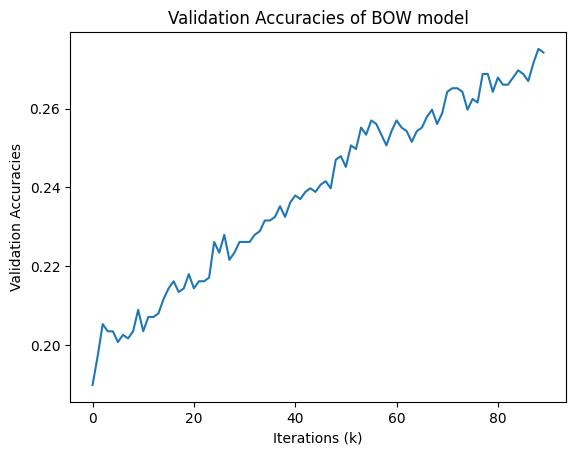

In [ ]:
# This will plot the validation accuracies across time.
plt.plot(bow_accuracies)
plt.xlabel('Iterations (k)')
plt.ylabel('Validation Accuracies')
plt.title('Validation Accuracies of BOW model');

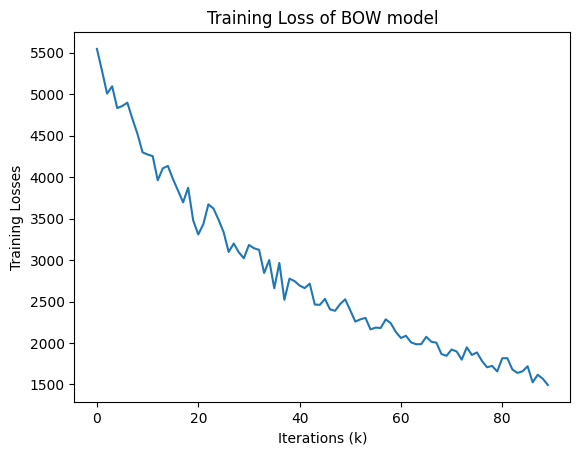

In [ ]:
# This will plot the training loss over time.
plt.plot(bow_losses)
plt.xlabel('Iterations (k)')
plt.ylabel('Training Losses')
plt.title('Training Loss of BOW model');

### Testing the BOW model

In [ ]:
def simple_evaluate_st(model, data, prep_fn):
    model.eval()
    detailed_results = defaultdict(lambda: {'total': 0, 'correct': 0})

    with torch.no_grad():
        for example in data:
            inputs, targets = prep_fn(example, model.vocab)
            inputs, targets = inputs.to(device), targets.to(device)


            sentence_length = inputs.size(1)

            outputs = model(inputs)
            predictions = outputs.argmax(dim=1)

            detailed_results[sentence_length]['total'] += targets.size(0)
            detailed_results[sentence_length]['correct'] += (predictions == targets).sum().item()

    return detailed_results

In [ ]:
# Test Accuracies across 3 runs with different random seeds

seeds = [10, 42, 50]
test_accs = []
sentences_bow = []
aggregated_sentences = defaultdict(lambda: {'total': 0, 'correct': 0, 'counts': 0})

for seed in seeds:
  set_seed(seed)
  bow_model = BOW(len(v.w2i), len(t2i), vocab=v)
  bow_model = bow_model.to(device)
  optimizer = optim.Adam(bow_model.parameters(), lr=0.0005)
  losses, accuracies, test_acc = train_model(
      bow_model, optimizer, num_iterations=80000,
      print_every=1000, eval_every=1000)
  test_accs.append(test_acc)
  _, _, _, sentences = simple_evaluate_st(
            bow_model, test_data,
            prep_fn=prepare_example)
  sentences_bow.append(sentences)

  for length, counts in sentences.items():
        aggregated_sentences[length]['total'] += counts['total']
        aggregated_sentences[length]['correct'] += counts['correct']
        aggregated_sentences[length]['counts'] += 1

mean_sentences_bow = {length: {'total': agg['total'] / agg['counts'],
                           'correct': agg['correct'] / agg['counts'],
                           'accuracy': (agg['correct'] / agg['total']) if agg['total'] > 0 else 0}
                  for length, agg in aggregated_sentences.items()}

mean_acc = np.mean(test_accs)
std_dev = np.std(test_accs)
print('Test Accuracy of BOW model:')
print("Test Accuracies: " + ", ".join(["{:.4f}".format(acc) for acc in test_accs]))
print("Mean accuracy={:.4f}, Standard Deviation={:.4f}".format(mean_acc, std_dev))

Shuffling training data
Iter 1000: loss=4969.4557, time=3.38s
iter 1000: dev acc=0.2044
new highscore
Iter 2000: loss=4575.4759, time=4.72s
iter 2000: dev acc=0.2098
new highscore
Iter 3000: loss=4484.9780, time=6.00s
iter 3000: dev acc=0.2116
new highscore
Iter 4000: loss=4636.7355, time=7.29s
iter 4000: dev acc=0.2098
Iter 5000: loss=4471.9061, time=8.56s
iter 5000: dev acc=0.2134
new highscore
Iter 6000: loss=4442.9174, time=9.92s
iter 6000: dev acc=0.2162
new highscore
Iter 7000: loss=4257.3095, time=11.19s
iter 7000: dev acc=0.2189
new highscore
Iter 8000: loss=4324.8011, time=12.43s
iter 8000: dev acc=0.2198
new highscore
Shuffling training data
Iter 9000: loss=4285.8300, time=14.89s
iter 9000: dev acc=0.2189
Iter 10000: loss=4050.1804, time=16.29s
iter 10000: dev acc=0.2162
Iter 11000: loss=4104.2792, time=17.55s
iter 11000: dev acc=0.2243
new highscore
Iter 12000: loss=3905.5728, time=18.84s
iter 12000: dev acc=0.2316
new highscore
Iter 13000: loss=3849.6818, time=20.11s
iter 1

# CBOW

We now continue with a **continuous bag-of-words (CBOW)** model. 

It is similar to the BOW model above, but now embeddings can have a dimension of *arbitrary size*.
This means that we can choose a higher dimensionality and learn more aspects of each word. We will still sum word vectors to get a sentence representation, but now the size of the resulting vector will no longer correspond to the number of sentiment classes.

So to turn the size of our summed vector into the number of output classes, we can *learn* a parameter matrix $W$ and multiply it by the sum vector $x$: $$Wx$$
If the size of $x$ is `d x 1`, we can set $W$ to be `5 x d`, so that the output of the matrix multiplication will be the of the desired size, `5 x 1`. Then, just like for the BOW model, we can obtain a prediction using the argmax function.

## implement and train the CBOW model

Write a class `CBOW` that:

- has word embeddings with size 300
- sums the word vectors for the input words
- projects the resulting vector down to 5 units using a linear layer and a bias term

Train CBOW model and plot the validation accuracy and training loss over time.

In [ ]:

class CBOW(nn.Module):

  def __init__(self, vocab_size, embedding_dim, outputclass_dim, vocab):
    super(CBOW, self).__init__()
    self.vocab = vocab

    # this is a trainable look-up table with word embeddings
    self.embed = nn.Embedding(vocab_size, embedding_dim)

    # this is a trainable linear layer weight matrix
    self.proj = nn.Linear(embedding_dim, outputclass_dim)


  def forward(self, inputs):
    
    embeds = self.embed(inputs)
    embeds_sum = embeds.sum(1)
    logits = self.proj(embeds_sum)

    return logits

In [ ]:
# Train the CBOW Model
cbow_model = CBOW(len(v.w2i), embedding_dim=300, outputclass_dim=len(t2i), vocab=v)
print(cbow_model)

cbow_model = cbow_model.to(device)

optimizer = optim.Adam(cbow_model.parameters(), lr=0.0005)
cbow_losses, cbow_accuracies, cbow_test = train_model(
    cbow_model, optimizer, num_iterations=50000,
    print_every=1000, eval_every=1000)

CBOW(
  (embed): Embedding(18280, 300)
  (proj): Linear(in_features=300, out_features=5, bias=True)
)
Shuffling training data
Iter 1000: loss=2651.2873, time=3.96s
iter 1000: dev acc=0.2443
new highscore
Iter 2000: loss=2312.6500, time=7.07s
iter 2000: dev acc=0.2452
new highscore
Iter 3000: loss=2026.8691, time=10.15s
iter 3000: dev acc=0.2489
new highscore
Iter 4000: loss=2073.9308, time=13.27s
iter 4000: dev acc=0.2489
Iter 5000: loss=1975.4979, time=16.30s
iter 5000: dev acc=0.2943
new highscore
Iter 6000: loss=1908.3391, time=19.43s
iter 6000: dev acc=0.2779
Iter 7000: loss=1836.8624, time=22.46s
iter 7000: dev acc=0.3206
new highscore
Iter 8000: loss=1860.6883, time=25.57s
iter 8000: dev acc=0.3270
new highscore
Shuffling training data
Iter 9000: loss=1776.7120, time=30.30s
iter 9000: dev acc=0.2906
Iter 10000: loss=1586.3001, time=33.31s
iter 10000: dev acc=0.3279
new highscore
Iter 11000: loss=1576.8006, time=36.48s
iter 11000: dev acc=0.3297
new highscore
Iter 12000: loss=1617

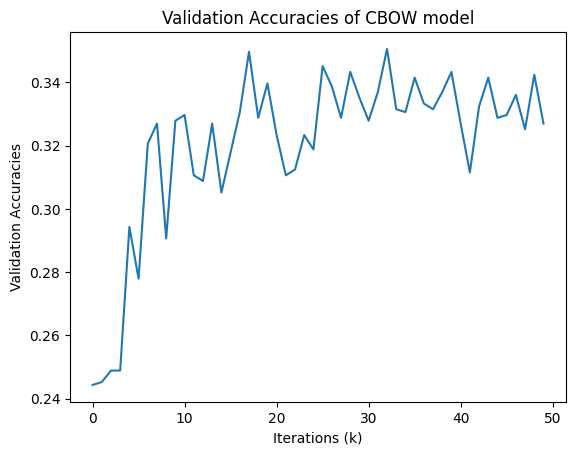

In [ ]:
# validation accuracies across time.
plt.plot(cbow_accuracies)
plt.xlabel('Iterations (k)')
plt.ylabel('Validation Accuracies')
plt.title('Validation Accuracies of CBOW model');

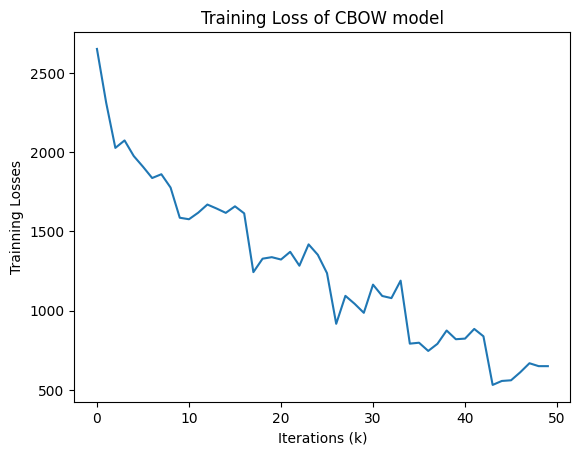

In [ ]:
# training loss over time.
plt.plot(cbow_losses)
plt.xlabel('Iterations (k)')
plt.ylabel('Trainning Losses')
plt.title('Training Loss of CBOW model');

## Testing the CBOW model

In [ ]:
# Test Accuracies across 3 runs with different random seed

seeds = [10, 42, 50]
test_accs = []
sentences_cbow = []
aggregated_sentences = defaultdict(lambda: {'total': 0, 'correct': 0, 'counts': 0})

for seed in seeds:
  set_seed(seed)
  cbow_model = CBOW(len(v.w2i), embedding_dim=300, outputclass_dim=len(t2i), vocab=v)
  cbow_model = cbow_model.to(device)
  optimizer = optim.Adam(cbow_model.parameters(), lr=0.0005)
  losses, accuracies, test_acc = train_model(
      cbow_model, optimizer, num_iterations=40000,
      print_every=1000, eval_every=1000)
  test_accs.append(test_acc)

  _, _, _, sentences = simple_evaluate_st(
            cbow_model, test_data,
            prep_fn=prepare_example)
  sentences_cbow.append(sentences)

  for length, counts in sentences.items():
        aggregated_sentences[length]['total'] += counts['total']
        aggregated_sentences[length]['correct'] += counts['correct']
        aggregated_sentences[length]['counts'] += 1

mean_sentences_cbow = {length: {'total': agg['total'] / agg['counts'],
                           'correct': agg['correct'] / agg['counts'],
                           'accuracy': (agg['correct'] / agg['total']) if agg['total'] > 0 else 0}
                  for length, agg in aggregated_sentences.items()}

mean_acc = np.mean(test_accs)
std_dev = np.std(test_accs)
print('Test Accuracy of CBOW model:')
print("Test Accuracies: " + ", ".join(["{:.4f}".format(acc) for acc in test_accs]))
print("Mean accuracy={:.4f}, Standard Deviation={:.4f}".format(mean_acc, std_dev))

Shuffling training data
Iter 1000: loss=2742.6175, time=2.69s
iter 1000: dev acc=0.2380
new highscore
Iter 2000: loss=2304.6035, time=4.59s
iter 2000: dev acc=0.2670
new highscore
Iter 3000: loss=2027.4385, time=6.56s
iter 3000: dev acc=0.2652
Iter 4000: loss=1971.6225, time=8.35s
iter 4000: dev acc=0.2725
new highscore
Iter 5000: loss=1872.1821, time=10.25s
iter 5000: dev acc=0.2698
Iter 6000: loss=1925.4796, time=12.07s
iter 6000: dev acc=0.3106
new highscore
Iter 7000: loss=1844.1147, time=14.01s
iter 7000: dev acc=0.2961
Iter 8000: loss=1896.1818, time=15.78s
iter 8000: dev acc=0.2952
Shuffling training data
Iter 9000: loss=1726.4705, time=19.18s
iter 9000: dev acc=0.2643
Iter 10000: loss=1566.7552, time=20.97s
iter 10000: dev acc=0.2879
Iter 11000: loss=1530.5791, time=22.72s
iter 11000: dev acc=0.2970
Iter 12000: loss=1637.7191, time=24.55s
iter 12000: dev acc=0.3061
Iter 13000: loss=1661.8713, time=26.43s
iter 13000: dev acc=0.2970
Iter 14000: loss=1607.7979, time=28.30s
iter 14

# Deep CBOW

To see if we can squeeze some more performance out of the CBOW model, we can make it deeper and non-linear by adding more layers and, e.g., tanh-activations.
By using more parameters we can learn more aspects of the data, and by using more layers and non-linearities, we can try to learn a more complex function.
This is not something that always works. If the input-output mapping of your data is simple, then a complicated function could easily overfit on your training set, thereby leading to poor generalization.

####  write Deep CBOW class and train it

Write a class `DeepCBOW`.

In your code, make sure that your `output_layer` consists of the following:
- A linear transformation from E units to D units.
- A Tanh activation
- A linear transformation from D units to D units
- A Tanh activation
- A linear transformation from D units to 5 units (our output classes).

E is the size of the word embeddings (please use E=300) and D for the size of a hidden layer (please use D=100).


In [ ]:

class DeepCBOW(nn.Sequential):

  def __init__(self, vocab_size, embedding_dim, hidden_units, outputclass_dim, vocab):
    super(DeepCBOW, self).__init__()
    self.vocab = vocab

    # embedding layer
    self.embed = nn.Embedding(vocab_size, embedding_dim)
    # hidden layer
    self.hidden_layer = nn.Sequential(
            nn.Linear(embedding_dim, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, outputclass_dim)
        )

  def forward(self, inputs):
    # embedding layer
    embeds = self.embed(inputs)
    embeds_sum = embeds.sum(1)
    # hidden layer
    logits = self.hidden_layer(embeds_sum)

    return logits

In [ ]:
# Train the Deep CBOW Model
dcbow_model = DeepCBOW(len(v.w2i), embedding_dim=300, hidden_units=100, outputclass_dim=len(t2i), vocab=v)
print(dcbow_model)

dcbow_model = dcbow_model.to(device)

optimizer = optim.Adam(dcbow_model.parameters(), lr=0.0005)
dcbow_losses, dcbow_accuracies, dcbow_test= train_model(
    dcbow_model, optimizer, num_iterations=30000,
    print_every=1000, eval_every=1000)

DeepCBOW(
  (embed): Embedding(18280, 300)
  (hidden_layer): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=5, bias=True)
  )
)
Shuffling training data
Iter 1000: loss=1602.2005, time=4.21s
iter 1000: dev acc=0.2897
new highscore
Iter 2000: loss=1569.0026, time=7.78s
iter 2000: dev acc=0.2979
new highscore
Iter 3000: loss=1557.5858, time=11.39s
iter 3000: dev acc=0.2997
new highscore
Iter 4000: loss=1524.6290, time=15.02s
iter 4000: dev acc=0.3152
new highscore
Iter 5000: loss=1549.0361, time=18.61s
iter 5000: dev acc=0.3106
Iter 6000: loss=1518.3768, time=22.05s
iter 6000: dev acc=0.3297
new highscore
Iter 7000: loss=1499.9756, time=25.66s
iter 7000: dev acc=0.3188
Iter 8000: loss=1488.2211, time=29.08s
iter 8000: dev acc=0.3506
new highscore
Shuffling training data
Iter 9000: loss=1453.3299, time=33.77s
iter 9000: dev a

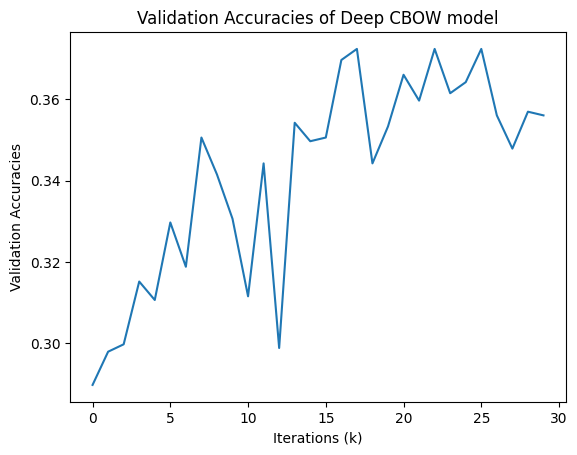

In [ ]:
# validation accuracies across time.
plt.plot(dcbow_accuracies)
plt.xlabel('Iterations (k)')
plt.ylabel('Validation Accuracies')
plt.title('Validation Accuracies of Deep CBOW model');

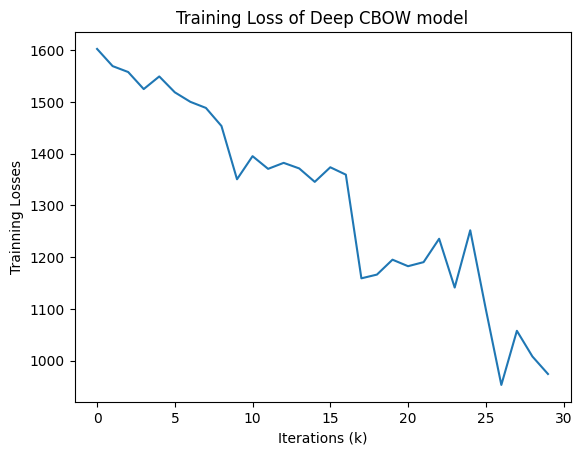

In [ ]:
# training loss over time.
plt.plot(dcbow_losses)
plt.xlabel('Iterations (k)')
plt.ylabel('Trainning Losses')
plt.title('Training Loss of Deep CBOW model');

## Testing the Deep CBOW model

In [ ]:
# Test Accuracies across 3 runs with different random seed


seeds = [10,42,50]
test_accs = []

sentences_dcbow = []
aggregated_sentences = defaultdict(lambda: {'total': 0, 'correct': 0, 'counts': 0})


for seed in seeds:
  set_seed(seed)
  dcbow_model = DeepCBOW(len(v.w2i), embedding_dim=300, hidden_units=100, outputclass_dim=len(t2i), vocab=v)
  dcbow_model = dcbow_model.to(device)
  optimizer = optim.Adam(dcbow_model.parameters(), lr=0.0005)
  losses, accuracies, test_acc = train_model(
      dcbow_model, optimizer, num_iterations=20000,
      print_every=1000, eval_every=1000)
  test_accs.append(test_acc)

  _, _, _, sentences = simple_evaluate_st(
            dcbow_model, test_data,
            prep_fn=prepare_example)
  sentences_dcbow.append(sentences)

  for length, counts in sentences.items():
        aggregated_sentences[length]['total'] += counts['total']
        aggregated_sentences[length]['correct'] += counts['correct']
        aggregated_sentences[length]['counts'] += 1

mean_sentences_dcbow = {length: {'total': agg['total'] / agg['counts'],
                           'correct': agg['correct'] / agg['counts'],
                           'accuracy': (agg['correct'] / agg['total']) if agg['total'] > 0 else 0}
                  for length, agg in aggregated_sentences.items()}
mean_acc = np.mean(test_accs)
std_dev = np.std(test_accs)
print('Test Accuracy of DCBOW model:')
print("Test Accuracies: " + ", ".join(["{:.4f}".format(acc) for acc in test_accs]))
print("Mean accuracy={:.4f}, Standard Deviation={:.4f}".format(mean_acc, std_dev))

Shuffling training data
Iter 1000: loss=1600.3424, time=3.05s
iter 1000: dev acc=0.2661
new highscore
Iter 2000: loss=1572.9202, time=5.36s
iter 2000: dev acc=0.2570
Iter 3000: loss=1530.9165, time=7.67s
iter 3000: dev acc=0.2752
new highscore
Iter 4000: loss=1537.4125, time=10.18s
iter 4000: dev acc=0.3115
new highscore
Iter 5000: loss=1533.7646, time=12.66s
iter 5000: dev acc=0.2888
Iter 6000: loss=1510.5317, time=14.90s
iter 6000: dev acc=0.3061
Iter 7000: loss=1510.8899, time=17.22s
iter 7000: dev acc=0.3015
Iter 8000: loss=1508.7015, time=19.48s
iter 8000: dev acc=0.3243
new highscore
Shuffling training data
Iter 9000: loss=1443.5838, time=23.45s
iter 9000: dev acc=0.3479
new highscore
Iter 10000: loss=1387.3092, time=25.95s
iter 10000: dev acc=0.3379
Iter 11000: loss=1333.8325, time=28.22s
iter 11000: dev acc=0.3270
Iter 12000: loss=1349.6621, time=30.50s
iter 12000: dev acc=0.3424
Iter 13000: loss=1376.7881, time=32.70s
iter 13000: dev acc=0.3333
Iter 14000: loss=1348.1948, time

# Pre-trained word embeddings

Leveraging Pre-trained Semantic Embeddings
Addressing Data Sparsity
The Stanford Sentiment Treebank (SST) is a high-precision but relatively small dataset due to its complex manual annotation. This sparsity makes it challenging for models like Deep CBOW to learn robust word representations from scratch, especially when the error signal is limited to sentence-level sentiment.

Integration of Pre-trained Vectors (GloVe)
To optimize the model's starting point, I integrated GloVe (Global Vectors for Word Representation). By initializing the lookup table with these pre-trained embeddings, the model begins with a sophisticated understanding of semantic relationships, where similar words are already positioned close to one another in the distributional semantic space.


Standardization: Following the methodology of the original Stanford Sentiment classification research, GloVe was selected to ensure result comparability and alignment with industry benchmarks.

Embedding Strategy: The embeddings are kept fixed during the initial training phase. This prevents the small dataset from distorting the well-generalized semantic space, allowing the model to focus on learning the composition logic rather than individual word meanings.

In [ ]:


!wget https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt

--2023-12-15 06:04:25--  https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53933315 (51M) [text/plain]
Saving to: ‘glove.840B.300d.sst.txt’

glove.840B.300d.sst 100%[===================>]  51.43M  --.-KB/s    in 0.1s    

2023-12-15 06:04:27 (448 MB/s) - ‘glove.840B.300d.sst.txt’ saved [53933315/53933315]



In [ ]:

!wget https://gist.githubusercontent.com/bastings/4d1c346c68969b95f2c34cfbc00ba0a0/raw/76b4fefc9ef635a79d0d8002522543bc53ca2683/googlenews.word2vec.300d.txt

--2023-12-15 06:04:27--  https://gist.githubusercontent.com/bastings/4d1c346c68969b95f2c34cfbc00ba0a0/raw/76b4fefc9ef635a79d0d8002522543bc53ca2683/googlenews.word2vec.300d.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66209703 (63M) [text/plain]
Saving to: ‘googlenews.word2vec.300d.txt’

googlenews.word2vec 100%[===================>]  63.14M   324MB/s    in 0.2s    

2023-12-15 06:04:30 (324 MB/s) - ‘googlenews.word2vec.300d.txt’ saved [66209703/66209703]



In [ ]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:

!cp "glove.840B.300d.sst.txt" "/gdrive/My Drive/"
!cp "googlenews.word2vec.300d.txt" "/gdrive/My Drive/"

In [ ]:


# Copy Glove vectors *from* Google Drive
!cp "/gdrive/My Drive/glove.840B.300d.sst.txt" .
!cp "/gdrive/My Drive/googlenews.word2vec.300d.txt" .

At this point you have the pre-trained word embedding files

In [ ]:
# Print the first 4 lines of the files that you downloaded.
print('Firt 4 lines in Glove')
!head -n 4 "glove.840B.300d.sst.txt"

print('Firt 4 lines in Word2Vec')
!head -n 4 "googlenews.word2vec.300d.txt"

Firt 4 lines in Glove
, -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 

#### New Vocabulary

Since we now use pre-trained word embeddings, we need to create a new vocabulary.
This is because of two reasons:

1. We do not have pre-trained word embeddings for all words in our SST training set, and we do not want words in our vocabulary for which we have no word embeddings.
2. We should be able to look up the pre-trained word embedding for words in the validation and test set, even if these words are unseen in training.

Now, create a new vocabulary object `v` based on the word set of pre-trained embeddings, and load the corresponding embeddings into a list `vectors`.

The vocabulary `v` should consist of:
 - a  `<unk>` token at position 0,
 - a  `<pad>` token at position 1,
 - and then all words in the pre-trained embedding set.


After storing each vector in a list `vectors`, turn the list into a numpy matrix like this:
```python
 vectors = np.stack(vectors, axis=0)
```



In [ ]:

v = Vocabulary()
v.add_token("<unk>")
v.add_token("<pad>")
embedding_dim = 300
# assign zero vector to <unk>
# assign zero vector to <pad>
vectors = [np.zeros(embedding_dim), np.zeros(embedding_dim)]

# Load pre_trained word embeddings
with open('glove.840B.300d.sst.txt', 'r', encoding='utf-8') as f:
  for index, line in enumerate(f):
    elements = line.split()
    word = elements[0]
    vector = np.asarray(elements[1:], dtype='float32')
    # v[word] = len(v)
    v.add_token(word)
    vectors.append(vector)

# Convert list vectors into numpy matrix
vectors = np.stack(vectors, axis=0)

In [ ]:
words_not_found = set()


def words_not_found_add(set):
  for example in set:
    for token in example.tokens:
      if token not in v.w2i:
        words_not_found.add(token)

words_not_found_add(train_data)
words_not_found_add(dev_data)
words_not_found_add(test_data)
# Glove
print('There are word vectors not in the pre-trained set', len(words_not_found))

There are word vectors not in the pre-trained set 976


#### train Deep CBOW with (fixed) pre-trained embeddings

Now train Deep CBOW again using the pre-trained word vectors.


In [ ]:
# We define a new class that inherits from DeepCBOW.
class PTDeepCBOW(DeepCBOW):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(PTDeepCBOW, self).__init__(
        vocab_size, embedding_dim, hidden_dim, output_dim, vocab)

In [ ]:
# Create a Deep CBOW model with pre-trained embeddings
# Train

pt_deep_cbow_model = PTDeepCBOW(len(v.w2i), embedding_dim=300, hidden_dim=100, output_dim=len(t2i), vocab=v)

# copy pre-trained word vectors into embeddings table
pt_deep_cbow_model.embed.weight.data.copy_(torch.from_numpy(vectors))

# disable training the pre-trained embeddings
pt_deep_cbow_model.embed.weight.requires_grad = False

# move model to specified device
pt_deep_cbow_model = pt_deep_cbow_model.to(device)

# train the model

optimizer = optim.Adam(pt_deep_cbow_model.parameters(), lr=0.0005)
pt_deep_cbow_losses, pt_deep_cbow_accuracies, pt_deep_cbow_test = train_model(
    pt_deep_cbow_model, optimizer, num_iterations=60000,
    print_every=1000, eval_every=1000)

Shuffling training data
Iter 1000: loss=1479.6408, time=2.91s
iter 1000: dev acc=0.3633
new highscore
Iter 2000: loss=1390.7856, time=4.69s
iter 2000: dev acc=0.3597
Iter 3000: loss=1338.3838, time=6.47s
iter 3000: dev acc=0.3560
Iter 4000: loss=1336.8796, time=8.40s
iter 4000: dev acc=0.3896
new highscore
Iter 5000: loss=1339.8444, time=10.21s
iter 5000: dev acc=0.3488
Iter 6000: loss=1357.5559, time=11.91s
iter 6000: dev acc=0.3896
Iter 7000: loss=1298.5945, time=13.69s
iter 7000: dev acc=0.4114
new highscore
Iter 8000: loss=1333.0645, time=15.56s
iter 8000: dev acc=0.4051
Shuffling training data
Iter 9000: loss=1327.4724, time=18.53s
iter 9000: dev acc=0.4169
new highscore
Iter 10000: loss=1272.8572, time=20.37s
iter 10000: dev acc=0.4105
Iter 11000: loss=1319.6480, time=22.08s
iter 11000: dev acc=0.4078
Iter 12000: loss=1281.8842, time=23.87s
iter 12000: dev acc=0.4051
Iter 13000: loss=1302.7666, time=25.70s
iter 13000: dev acc=0.3978
Iter 14000: loss=1313.3429, time=27.48s
iter 14

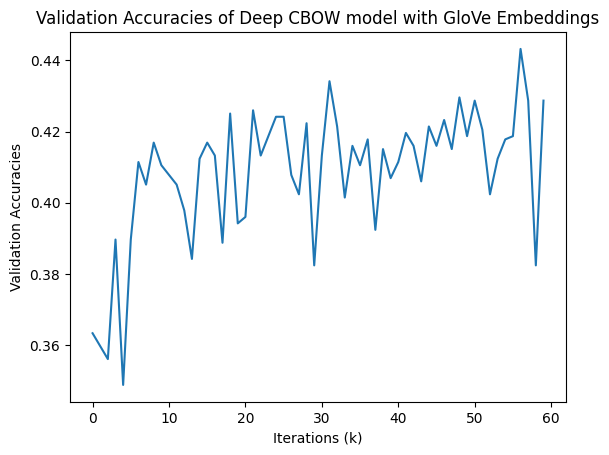

In [ ]:
# plot dev accuracies
plt.plot(pt_deep_cbow_accuracies)
plt.xlabel('Iterations (k)')
plt.ylabel('Validation Accuracies')
plt.title('Validation Accuracies of Deep CBOW model with GloVe Embeddings');

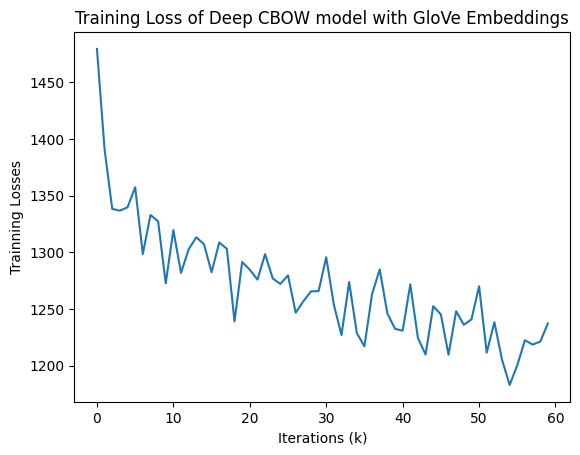

In [ ]:
# plot train loss
plt.plot(pt_deep_cbow_losses)
plt.xlabel('Iterations (k)')
plt.ylabel('Trainning Losses')
plt.title('Training Loss of Deep CBOW model with GloVe Embeddings');

## Testing the Deep CBOW model with (fixed) pre-trained embeddings

In [ ]:
# Test Accuracies across 3 runs with different random seed


seeds = [10,42,50]
test_accs = []

sentences_dcbow_pt = []
aggregated_sentences = defaultdict(lambda: {'total': 0, 'correct': 0, 'counts': 0})

for seed in seeds:
  set_seed(seed)
  pt_deep_cbow_model = PTDeepCBOW(len(v.w2i), embedding_dim=300, hidden_dim=100, output_dim=len(t2i), vocab=v)
  pt_deep_cbow_model = pt_deep_cbow_model.to(device)
  optimizer = optim.Adam(pt_deep_cbow_model.parameters(), lr=0.0005)
  losses, accuracies, test_acc = train_model(
      pt_deep_cbow_model, optimizer, num_iterations=45000,
      print_every=1000, eval_every=1000)
  test_accs.append(test_acc)

  _, _, _, sentences = simple_evaluate_st(
            pt_deep_cbow_model, test_data,
            prep_fn=prepare_example)
  sentences_dcbow_pt.append(sentences)

  for length, counts in sentences.items():
        aggregated_sentences[length]['total'] += counts['total']
        aggregated_sentences[length]['correct'] += counts['correct']
        aggregated_sentences[length]['counts'] += 1

mean_sentences_dcbow_pt = {length: {'total': agg['total'] / agg['counts'],
                           'correct': agg['correct'] / agg['counts'],
                           'accuracy': (agg['correct'] / agg['total']) if agg['total'] > 0 else 0}
                  for length, agg in aggregated_sentences.items()}

mean_acc = np.mean(test_accs)
std_dev = np.std(test_accs)
print('Test Accuracy of DCBOW model with fixed GloVe embeddings:')
print("Test Accuracies: " + ", ".join(["{:.4f}".format(acc) for acc in test_accs]))
print("Mean accuracy={:.4f}, Standard Deviation={:.4f}".format(mean_acc, std_dev))

Shuffling training data
Iter 1000: loss=1602.1768, time=3.34s
iter 1000: dev acc=0.2961
new highscore
Iter 2000: loss=1573.3435, time=5.85s
iter 2000: dev acc=0.2725
Iter 3000: loss=1534.0798, time=8.32s
iter 3000: dev acc=0.2816
Iter 4000: loss=1520.4024, time=10.63s
iter 4000: dev acc=0.3052
new highscore
Iter 5000: loss=1536.9323, time=13.21s
iter 5000: dev acc=0.2852
Iter 6000: loss=1528.6854, time=15.60s
iter 6000: dev acc=0.2734
Iter 7000: loss=1510.4999, time=17.94s
iter 7000: dev acc=0.3052
Iter 8000: loss=1514.7289, time=20.27s
iter 8000: dev acc=0.3197
new highscore
Shuffling training data
Iter 9000: loss=1465.6065, time=23.98s
iter 9000: dev acc=0.3361
new highscore
Iter 10000: loss=1397.3190, time=26.53s
iter 10000: dev acc=0.3315
Iter 11000: loss=1383.3533, time=28.88s
iter 11000: dev acc=0.3297
Iter 12000: loss=1382.1855, time=31.17s
iter 12000: dev acc=0.3569
new highscore
Iter 13000: loss=1400.1518, time=33.74s
iter 13000: dev acc=0.3188
Iter 14000: loss=1378.8463, time

# LSTM

Even with pre-trained word embeddings and multiple layers, we still seem to do pretty badly at sentiment classification.
The next step we can take is to introduce word order again, dropping our independence assumptions. In this way, we can get a representation of the sentence as an ordered set of tokens.

We will get this representation using a **Long Short-Term Memory** (LSTM). As an experiment, we will code our own LSTM cell, so that we get comfortable with its inner workings.
Once we have an LSTM cell, we can call it repeatedly, updating its hidden state one word at a time:

```python
rnn = MyLSTMCell(input_size, hidden_size)

hx = torch.zeros(1, hidden_size)  # initial hidden state
cx = torch.zeros(1, hidden_size)  # initial memory cell
output = []                       # to save intermediate LSTM states

# feed one word at a time
for i in range(n_timesteps):
  hx, cx = rnn(input[i], (hx, cx))
  output.append(hx)
```



####  Finish the LSTM cell below.
You will need to implement the LSTM formulas:

$$
\begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o \tanh(c') \\
\end{array}
 $$

where $\sigma$ is the sigmoid function.


In [ ]:
class MyLSTMCell(nn.Module):
  """Our own LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(MyLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias ###？###

    
    # Forget gate parameters
    self.W_if = nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.b_if = nn.Parameter(torch.Tensor(hidden_size))
    self.W_hf = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.b_hf = nn.Parameter(torch.Tensor(hidden_size))

    # Input gate parameters
    self.W_ii = nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.b_ii = nn.Parameter(torch.Tensor(hidden_size))
    self.W_hi = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.b_hi = nn.Parameter(torch.Tensor(hidden_size))

    # Candidate values parameters
    self.W_ig = nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.b_ig = nn.Parameter(torch.Tensor(hidden_size))
    self.W_hg = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.b_hg = nn.Parameter(torch.Tensor(hidden_size))

    # Output gate parameters
    self.W_io = nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.b_io = nn.Parameter(torch.Tensor(hidden_size))
    self.W_ho = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.b_ho = nn.Parameter(torch.Tensor(hidden_size))

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, input_, hx, mask=None):
    """
    input is (batch, input_size)
    hx is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h, prev_c = hx

    # project input and prev state
   
    x = input_

    # raise NotImplementedError("Implement this")

    # main LSTM computation

    i = torch.sigmoid(x @ self.W_ii + self.b_ii + prev_h @ self.W_hi  + self.b_hi)
    f = torch.sigmoid(x @ self.W_if + self.b_if + prev_h @ self.W_hf  + self.b_hf)
    g = torch.tanh(x @ self.W_ig + self.b_ig + prev_h @ self.W_hg  + self.b_hg)
    o = torch.sigmoid(x @ self.W_io + self.b_io + prev_h @ self.W_ho  + self.b_ho)

    c = f * prev_c + i * g
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

#### Efficient Matrix Multiplication

It is more efficient to do a few big matrix multiplications than to do many smaller ones. So we will implement the above cell using just **two** linear layers.

This is possible because the eight linear transformations contained in one forward pass through an LSTM cell can be reduced to just two:
$$W_h h + b_h$$
$$W_i x + b_i $$

with $h = $ `prev_h` and $x = $ `input_`.

and where:

$W_h =  \begin{pmatrix}
W_{hi}\\
W_{hf}\\
W_{hg}\\
W_{ho}
\end{pmatrix}$, $b_h = \begin{pmatrix}
b_{hi}\\
b_{hf}\\
b_{hg}\\
b_{ho}
\end{pmatrix}$,  $W_i = \begin{pmatrix}
W_{ii}\\
W_{if}\\
W_{ig}\\
W_{io}
\end{pmatrix}$ and $b_i = \begin{pmatrix}
b_{ii}\\
b_{if}\\
b_{ig}\\
b_{io}
\end{pmatrix}$.


In [ ]:
class MyLSTMCell_chunk(nn.Module):
  """Our own LSTM cell with torch.chunk"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(MyLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    # Combined parameters
    self.W_i = nn.Parameter(torch.Tensor(input_size, 4*hidden_size))
    self.W_h = nn.Parameter(torch.Tensor(4*hidden_size, hidden_size))
    self.b_i = nn.Parameter(torch.Tensor(4*hidden_size,))
    self.b_h = nn.Parameter(torch.Tensor(4*hidden_size,))

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, input_, hx, mask=None):
    """
    input is (batch, input_size)
    hx is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h, prev_c = hx

    # project input and prev state
    x = input_

    # raise NotImplementedError("Implement this")

    # main LSTM computation
    all_projection = x @ self.W_i + self.b_i + prev_h @ self.W_h + self.b_h
    i, f, g, o = torch.chunk(all_projection, 4, dim=1)

    i = torch.sigmoid(i)
    f = torch.sigmoid(f)
    g = torch.tanh(g)
    o = torch.sigmoid(o)

    c = f.T * prev_c + i.T * g
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

#### LSTM Classifier

Having an LSTM cell is not enough: we still need some code that calls it repeatedly, and then makes a prediction from the final hidden state.

In [ ]:
class LSTMClassifier(nn.Module):
  """Encodes sentence with an LSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(LSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.rnn = MyLSTMCell(embedding_dim, hidden_dim)

    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),  # explained later (below)
        nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, x):

    B = x.size(0)  # batch size (this is 1 for now, i.e. 1 single example)
    T = x.size(1)  # timesteps (the number of words in the sentence)

    input_ = self.embed(x)

   
    hx = input_.new_zeros(B, self.rnn.hidden_size)
    cx = input_.new_zeros(B, self.rnn.hidden_size)

   
    # so the first word(s) is (are) input_[:, 0]
    outputs = []
    for i in range(T):
      hx, cx = self.rnn(input_[:, i], (hx, cx))
      outputs.append(hx)

    # if we have a single example, our final LSTM state is the last hx
    if B == 1:
      final = hx
    else:

      # two lines below not needed if using LSTM from pytorch
      outputs = torch.stack(outputs, dim=0)           # [T, B, D]
      outputs = outputs.transpose(0, 1).contiguous()  # [B, T, D]

      
      # we zero out positions that are invalid
      pad_positions = (x == 1).unsqueeze(-1)

      outputs = outputs.contiguous()
      outputs = outputs.masked_fill_(pad_positions, 0.)

      mask = (x != 1)  # true for valid positions [B, T]
      lengths = mask.sum(dim=1)                 # [B, 1]

      indexes = (lengths - 1) + torch.arange(B, device=x.device, dtype=x.dtype) * T
      final = outputs.view(-1, self.hidden_dim)[indexes]  # [B, D]

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(final)
    return logits

#### Dropout

Data sparsity and a small data set can cause *overfitting*. This is a phenomenom that is very likely to occur when training strong and expressive models, like LSTMs, on small data. In practice, if your model overfits, this means that it will be very good at predicting (or "remembering") the sentiment of the training set, but unable to generalise to new, unseen data in the test set. This is undesirable and one technique to mitigate this issue is *dropout*.

A dropout layer is defined by the following formula, which can be applied, for example, to a linear layer:

$$\text{tanh}(W(\mathbf{h}\odot \mathbf{d}) + \mathbf{b})$$

where $\mathbf{d} \in \{0, 1\}^n$, with $d_j \sim \text{Bernoulli}(p)$,

These formula simply means that we *drop* certain parameters during training (by setting them to zero). Which parameters we drop is stochastically determined by a Bernoulli distribution and the probability of each parameter being dropped is set to $p = 0.5$ in our experiments (see the previous cell of code where we define our output layer). A dropout layer can be applied at many different places in our models. This technique helps against the undesirable effect that a model relies on single parameters for prediction (e.g. if $h^{\prime}_j$ is large, always predict positive). If we use dropout, the model needs to learn to rely on different parameters, which is desirable to obtain better generalisation to unseen data.

**train our LSTM!** 

#### Training

In [ ]:
lstm_model = LSTMClassifier(len(v.w2i), 300, 168, len(t2i), v)

# copy pre-trained word vectors into embeddings table
with torch.no_grad():
  lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  lstm_model.embed.weight.requires_grad = False

print(lstm_model)
print_parameters(lstm_model)

lstm_model = lstm_model.to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)

lstm_losses, lstm_accuracies, test_accuracies = train_model(
    lstm_model, optimizer, num_iterations=40000,
    print_every=250, eval_every=1000)

LSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=False
rnn.W_if                 [300, 168]   requires_grad=True
rnn.b_if                 [168]        requires_grad=True
rnn.W_hf                 [168, 168]   requires_grad=True
rnn.b_hf                 [168]        requires_grad=True
rnn.W_ii                 [300, 168]   requires_grad=True
rnn.b_ii                 [168]        requires_grad=True
rnn.W_hi                 [168, 168]   requires_grad=True
rnn.b_hi                 [168]        requires_grad=True
rnn.W_ig                 [300, 168]   requires_grad=True
rnn.b_ig                 [168]        requires_grad=True
rnn.W_hg                 [168, 168]   requires_grad=True
rnn.b_hg                 [168]        requires_grad=True
rnn.W_io                 [300

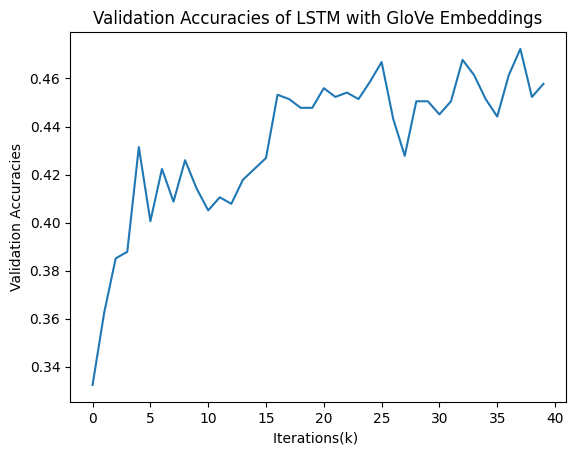

In [ ]:
# plot validation accuracy
plt.plot(lstm_accuracies)
plt.xlabel('Iterations(k) ')
plt.ylabel('Validation Accuracies')
plt.title('Validation Accuracies of LSTM with GloVe Embeddings');

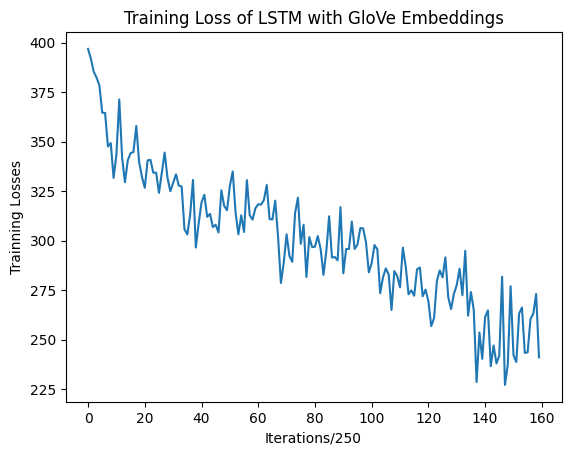

In [ ]:
# plot training loss
plt.plot(lstm_losses)
plt.xlabel('Iterations/250')
plt.ylabel('Trainning Losses')
plt.title('Training Loss of LSTM with GloVe Embeddings');

### Testing

In [ ]:
# Test Accuracies across 3 runs with different random seed


seeds = [10,42,50]
test_accs = []

sentences_lstm = []
aggregated_sentences = defaultdict(lambda: {'total': 0, 'correct': 0, 'counts': 0})

for seed in seeds:
  set_seed(seed)
  lstm_model = LSTMClassifier(len(v.w2i), 300, 168, len(t2i), v)
  # copy pre-trained word vectors into embeddings table
  with torch.no_grad():
    lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    lstm_model.embed.weight.requires_grad = False
  lstm_model = lstm_model.to(device)
  optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)
  losses, accuracies, test_acc = train_model(
      lstm_model, optimizer, num_iterations=40000,
      print_every=250, eval_every=1000)
  test_accs.append(test_acc)

  _, _, _, sentences = simple_evaluate_st(
            lstm_model, test_data,
            prep_fn=prepare_example)
  sentences_lstm.append(sentences)

  for length, counts in sentences.items():
        aggregated_sentences[length]['total'] += counts['total']
        aggregated_sentences[length]['correct'] += counts['correct']
        aggregated_sentences[length]['counts'] += 1

mean_sentences_lstm = {length: {'total': agg['total'] / agg['counts'],
                           'correct': agg['correct'] / agg['counts'],
                           'accuracy': (agg['correct'] / agg['total']) if agg['total'] > 0 else 0}
                  for length, agg in aggregated_sentences.items()}

mean_acc = np.mean(test_accs)
std_dev = np.std(test_accs)
print('Test Accuracy of LSTM with GloVe Embeddings:')
print("Test Accuracies: " + ", ".join(["{:.4f}".format(acc) for acc in test_accs]))
print("Mean accuracy={:.4f}, Standard Deviation={:.4f}".format(mean_acc, std_dev))

Shuffling training data
Iter 250: loss=396.9969, time=7.86s
Iter 500: loss=396.3926, time=13.78s
Iter 750: loss=384.0541, time=20.41s
Iter 1000: loss=365.5361, time=26.62s
iter 1000: dev acc=0.3451
new highscore
Iter 1250: loss=374.3186, time=42.89s
Iter 1500: loss=369.2123, time=48.97s
Iter 1750: loss=352.5190, time=55.37s
Iter 2000: loss=365.8286, time=61.87s
iter 2000: dev acc=0.4060
new highscore
Iter 2250: loss=343.4378, time=77.87s
Iter 2500: loss=357.6473, time=84.30s
Iter 2750: loss=347.7334, time=90.41s
Iter 3000: loss=358.5592, time=96.52s
iter 3000: dev acc=0.3778
Iter 3250: loss=348.8845, time=112.38s
Iter 3500: loss=337.3491, time=118.70s
Iter 3750: loss=342.4543, time=124.77s
Iter 4000: loss=342.5153, time=130.87s
iter 4000: dev acc=0.3842
Iter 4250: loss=329.4043, time=147.04s
Iter 4500: loss=352.0246, time=153.69s
Iter 4750: loss=329.9086, time=160.07s
Iter 5000: loss=344.7537, time=166.02s
iter 5000: dev acc=0.3942
Iter 5250: loss=327.5614, time=182.97s
Iter 5500: loss

# Mini-batching



**Why is the LSTM so slow?** Despite our best efforts, we still need to make a lot of matrix multiplications per example (linear in the length of the example) just to get a single classification, and we can only process the 2nd word once we have computed the hidden state for the 1st word (sequential computation).

GPUs are more efficient if we do a few big matrix multiplications, rather than lots of small ones. If we could process multiple examples at the same time, then we could exploit that. That is, we could still process the input sequentially, but doing so for multiple sentences at the same time.

Up to now our "mini-batches" consisted of a single example. This was for a reason: the sentences in our data sets have **different lengths**, and this makes it difficult to process them at the same time.

Consider a batch of 2 sentences:

```
this movie is bad
this movie is super cool !
```

Let's say the IDs for these sentences are:

```
2 3 4 5
2 3 4 6 7 8
```

We cannot feed PyTorch an object with rows of variable length! We need to turn this into a matrix.

The solution is to add **padding values** to our mini-batch:

```
2 3 4 5 1 1
2 3 4 6 7 8
```

Whenever a sentence is shorter than the longest sentence in a mini-batch, we just use a padding value (here: 1) to fill the matrix.

In our computation, we should **ignore** the padding positions (e.g. mask them out) so that paddings do not contribute to the loss.

#### Mini-batch feed
We will now implement a `get_minibatch` function which will replace `get_example` and returns a mini-batch of the requested size.

In [ ]:
def get_minibatch(data, batch_size=25, shuffle=True):
  """Return minibatches, optional shuffling"""
  # Create a deep copy of the data to ensure that each run with a given seed
  # has a consistent data sequence
  data_copy = deepcopy(data)
  if shuffle:
    print("Shuffling training data")
    random.shuffle(data_copy)  # shuffle training data each epoch

  batch = []

  # yield minibatches
  for example in data_copy:
    batch.append(example)

    if len(batch) == batch_size:
      yield batch
      batch = []

  # in case there is something left
  if len(batch) > 0:
    yield batch

#### Padding function
We will need a function that adds padding 1s to a sequence of IDs so that
it becomes as long as the longest sequence in the minibatch.

In [ ]:
def pad(tokens, length, pad_value=1):
  """add padding 1s to a sequence to that it has the desired length"""
  return tokens + [pad_value] * (length - len(tokens))

# example
tokens = [2, 3, 4]
pad(tokens, 5)

[2, 3, 4, 1, 1]

#### New `prepare` function

We will also need a new function that turns a mini-batch into PyTorch tensors.

In [ ]:
def prepare_minibatch(mb, vocab):
  """
  Minibatch is a list of examples.
  This function converts words to IDs and returns
  torch tensors to be used as input/targets.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen) for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  return x, y

In [ ]:
# Let's test our new function.
# This should give us 3 examples.
mb = next(get_minibatch(train_data, batch_size=3, shuffle=False))
for ex in mb:
  print(ex)

Example(tokens=['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], tree=Tree('3', [Tree('2', [Tree('2', ['The']), Tree('2', ['Rock'])]), Tree('4', [Tree('3', [Tree('2', ['is']), Tree('4', [Tree('2', ['destined']), Tree('2', [Tree('2', [Tree('2', [Tree('2', [Tree('2', ['to']), Tree('2', [Tree('2', ['be']), Tree('2', [Tree('2', ['the']), Tree('2', [Tree('2', ['21st']), Tree('2', [Tree('2', [Tree('2', ['Century']), Tree('2', ["'s"])]), Tree('2', [Tree('3', ['new']), Tree('2', [Tree('2', ['``']), Tree('2', ['Conan'])])])])])])])]), Tree('2', ["''"])]), Tree('2', ['and'])]), Tree('3', [Tree('2', ['that']), Tree('3', [Tree('2', ['he']), Tree('3', [Tree('2', ["'s"]), Tree('3', [Tree('2', ['going']), Tree('3', [Tree('2', ['to']), Tree('4', [Tree('3', [Tree('

In [ ]:
# We should find padding 1s at the end
x, y = prepare_minibatch(mb, v)
print("x", x)
print("y", y)

x tensor([[   23,  1414,    11,  8222,     6,    27,     4,  2826,  3764,    21,
            92,  5233,  8558, 15010,     5,    16,    53,    21,   183,     6,
           107,     8,  7409,   148,  1552,    97,  6000, 10464,     2,     0,
          2740, 15451,    33,  4008, 12925,     3,     1,     1,     1],
        [   23, 15300,  6665,  8307,     7,  5233,    23,  1383,     7,     4,
          4884, 15010,  8681,    11,    59,   933,    16,     8,  3045,     7,
           566,    42,    36,  7800,  2886, 20302,  1433,  1977,    21,  4360,
          2274,     7, 15256, 10099,    21, 15561,     3,     1,     1],
        [    0,  5314,  3878,  7735,     8,  9726,     7,  1261,   158,     8,
           219,  1060,  2187,     2,     8,   219,    50,   688, 11605,     6,
             4,   414,   158,    43,     4,   494,  1568,  1214,  6985,     4,
          2243,     2,  5986,     2,  2320,     7,     4,   982,     3]],
       device='cuda:0')
y tensor([3, 4, 3], device='cuda:0')


#### Evaluate (mini-batch version)

We can now update our evaluation function to use mini-batches

In [ ]:
def evaluate(model, data,
             batch_fn=get_minibatch, prep_fn=prepare_minibatch,
             batch_size=16):
  """Accuracy of a model on given data set (using mini-batches)"""
  correct = 0
  total = 0
  model.eval()  # disable dropout

  for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
    x, targets = prep_fn(mb, model.vocab)
    with torch.no_grad():
      logits = model(x)

    predictions = logits.argmax(dim=-1).view(-1)

    # add the number of correct predictions to the total correct
    correct += (predictions == targets.view(-1)).sum().item()
    total += targets.size(0)

  return correct, total, correct / float(total)

#### Evaluate with batch of different sentence length

In [ ]:
def get_minibatch_sl(data, batch_size=25):
  """Return minibatches, optional shuffling"""
  # Create a deep copy of the data to ensure that each run with a given seed
  # has a consistent data sequence
  data_copy = deepcopy(data)
  # Sort data by sentence length
  sorted_data = sorted(data_copy, key=lambda x: len(x.tokens))


  batch = []

  # yield minibatches
  for example in sorted_data:
    batch.append(example)

    if len(batch) == batch_size:
      yield batch
      batch = []

  # in case there is something left
  if len(batch) > 0:
    yield batch

In [ ]:
def evaluate_sl(model, data,
             batch_fn=get_minibatch_sl, prep_fn=prepare_minibatch,
             batch_size=16):
  """Accuracy of a model on given data set (using mini-batches)"""
  correct = 0
  total = 0
  batch_accuracies = {}
  model.eval()  # disable dropout

  for mb in batch_fn(data, batch_size=batch_size):
    # mean_sentence_length = sum(len(example.tokens) for example in mb) / len(mb)
    max_sentence_length = max(len(example.tokens) for example in mb)
    x, targets = prep_fn(mb, model.vocab)
    with torch.no_grad():
      logits = model(x)

    predictions = logits.argmax(dim=-1).view(-1)

    # Calculate the number of correct predictions for the minibatch
    num_correct = (predictions == targets.view(-1)).sum().item()
    num_total = targets.size(0)

    # add the number of correct predictions to the total correct
    correct += num_correct
    total += num_total

    # Calculate the accuracy for the minibatch and store it
    batch_accuracy = num_correct / float(num_total)
    batch_accuracies[max_sentence_length] = batch_accuracy

    overall_accuracy = correct / float(total)

  return correct, total, correct / float(total), batch_accuracies

# LSTM (Mini-batched)

With this, let's run the LSTM again but now using mini-batches!

In [ ]:
lstm_model = LSTMClassifier(
    len(v.w2i), 300, 168, len(t2i), v)

# copy pre-trained vectors into embeddings table
with torch.no_grad():
  lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  lstm_model.embed.weight.requires_grad = False

print(lstm_model)
print_parameters(lstm_model)

lstm_model = lstm_model.to(device)

batch_size = 25
optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)

lstm_mb_losses, lstm_mb_accuracies, test_accr = train_model(
    lstm_model, optimizer, num_iterations=30000,
    print_every=250, eval_every=250,
    batch_size=batch_size,
    batch_fn=get_minibatch,
    prep_fn=prepare_minibatch,
    eval_fn=evaluate)

LSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=False
rnn.W_if                 [300, 168]   requires_grad=True
rnn.b_if                 [168]        requires_grad=True
rnn.W_hf                 [168, 168]   requires_grad=True
rnn.b_hf                 [168]        requires_grad=True
rnn.W_ii                 [300, 168]   requires_grad=True
rnn.b_ii                 [168]        requires_grad=True
rnn.W_hi                 [168, 168]   requires_grad=True
rnn.b_hi                 [168]        requires_grad=True
rnn.W_ig                 [300, 168]   requires_grad=True
rnn.b_ig                 [168]        requires_grad=True
rnn.W_hg                 [168, 168]   requires_grad=True
rnn.b_hg                 [168]        requires_grad=True
rnn.W_io                 [300

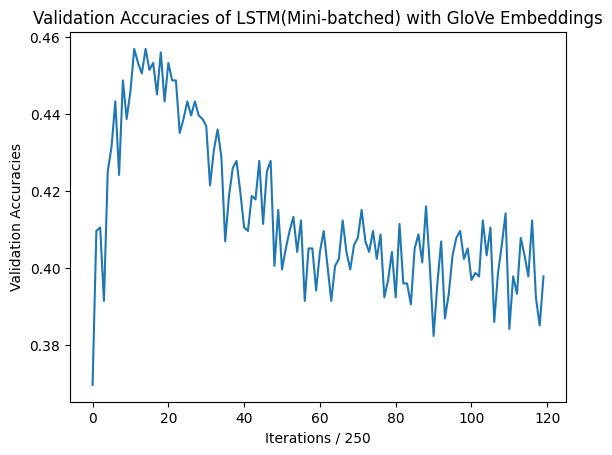

In [ ]:
# plot validation accuracy
plt.plot(lstm_mb_accuracies)
plt.xlabel('Iterations / 250')
plt.ylabel('Validation Accuracies')
plt.title('Validation Accuracies of LSTM(Mini-batched) with GloVe Embeddings');

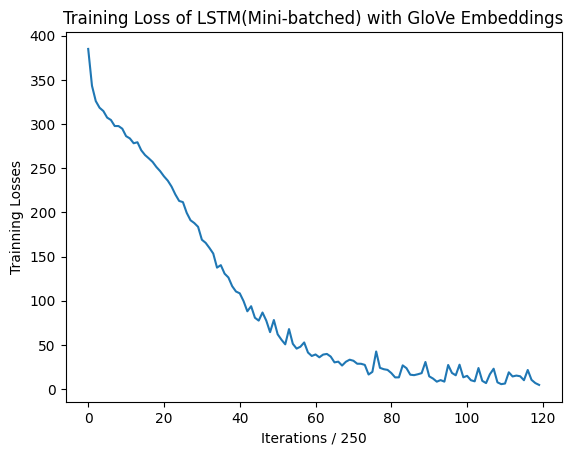

In [ ]:
# plot training loss
plt.plot(lstm_mb_losses)
plt.xlabel('Iterations / 250')
plt.ylabel('Trainning Losses')
plt.title('Training Loss of LSTM(Mini-batched) with GloVe Embeddings');

>According to the plotted graphs, the model's convergence to its optimal state at around 4750th iteration. Hence, we will set the number of iterations to 5000 when testing the model across three different random seeds.

In [ ]:
# Test Accuracies across 3 runs with different random seed

seeds = [10,42,50]
test_accs = []
batch_size = 25

sentences_lstm_mb = []
aggregated_accuracies = defaultdict(list)

for seed in seeds:
  set_seed(seed)
  lstm_model = LSTMClassifier(len(v.w2i), 300, 168, len(t2i), v)
  # copy pre-trained word vectors into embeddings table
  with torch.no_grad():
    lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    lstm_model.embed.weight.requires_grad = False
  lstm_model = lstm_model.to(device)
  optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)
  losses, accuracies, test_acc = train_model(
      lstm_model, optimizer, num_iterations=5000,
      print_every=250, eval_every=250, batch_size=batch_size,
      batch_fn=get_minibatch, prep_fn=prepare_minibatch, eval_fn=evaluate)
  test_accs.append(test_acc)

  _, _, _, batch_accuracies = evaluate_sl(
            lstm_model, test_data,
            batch_fn=get_minibatch_sl, prep_fn=prepare_minibatch,
            batch_size=batch_size)

  # Aggregate the batch accuracies
  for mean_length, accuracy in batch_accuracies.items():
    aggregated_accuracies[mean_length].append(accuracy)

# Calculate the mean and standard deviation of accuracies across seeds
mean_sentences_lstm_mb = {length: np.mean(accs) for length, accs in aggregated_accuracies.items()}
std_dev_sentences_lstm_mb = {length: np.std(accs) for length, accs in aggregated_accuracies.items()}

mean_acc = np.mean(test_accs)
std_dev = np.std(test_accs)
print('Test Accuracy of LSTM(Mini-batched) with GloVe Embeddings:')
print("Test Accuracies: " + ", ".join(["{:.4f}".format(acc) for acc in test_accs]))
print("Mean accuracy={:.4f}, Standard Deviation={:.4f}".format(mean_acc, std_dev))



Shuffling training data
Iter 250: loss=385.0830, time=14.53s
iter 250: dev acc=0.3742
new highscore
Shuffling training data
Iter 500: loss=341.1252, time=29.72s
iter 500: dev acc=0.4078
new highscore
Shuffling training data
Iter 750: loss=326.9134, time=44.78s
iter 750: dev acc=0.4096
new highscore
Iter 1000: loss=322.0371, time=59.15s
iter 1000: dev acc=0.4205
new highscore
Shuffling training data
Iter 1250: loss=312.4711, time=73.59s
iter 1250: dev acc=0.4278
new highscore
Shuffling training data
Iter 1500: loss=311.0420, time=88.47s
iter 1500: dev acc=0.4332
new highscore
Shuffling training data
Iter 1750: loss=303.1148, time=103.71s
iter 1750: dev acc=0.4287
Iter 2000: loss=299.9523, time=117.37s
iter 2000: dev acc=0.4505
new highscore
Shuffling training data
Iter 2250: loss=295.2385, time=132.51s
iter 2250: dev acc=0.4414
Shuffling training data
Iter 2500: loss=290.5408, time=146.99s
iter 2500: dev acc=0.4559
new highscore
Shuffling training data
Iter 2750: loss=291.1480, time=161

Fine-tuning word embeddings

In [ ]:
lstm_model = LSTMClassifier(
    len(v.w2i), 300, 168, len(t2i), v)

# Now fine-tune your embeddings together with the model

with torch.no_grad():
  lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  lstm_model.embed.weight.requires_grad = True #word embedings update with the model

print(lstm_model)
print_parameters(lstm_model)

lstm_model = lstm_model.to(device)

batch_size = 25
optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)

lstm_mb_fine_losses, lstm_mb_fine_accuracies, test_accuracies = train_model(
    lstm_model, optimizer, num_iterations=1000,
    print_every=50, eval_every=50,
    batch_size=batch_size,
    batch_fn=get_minibatch,
    prep_fn=prepare_minibatch,
    eval_fn=evaluate)

LSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=True
rnn.W_if                 [300, 168]   requires_grad=True
rnn.b_if                 [168]        requires_grad=True
rnn.W_hf                 [168, 168]   requires_grad=True
rnn.b_hf                 [168]        requires_grad=True
rnn.W_ii                 [300, 168]   requires_grad=True
rnn.b_ii                 [168]        requires_grad=True
rnn.W_hi                 [168, 168]   requires_grad=True
rnn.b_hi                 [168]        requires_grad=True
rnn.W_ig                 [300, 168]   requires_grad=True
rnn.b_ig                 [168]        requires_grad=True
rnn.W_hg                 [168, 168]   requires_grad=True
rnn.b_hg                 [168]        requires_grad=True
rnn.W_io                 [300,

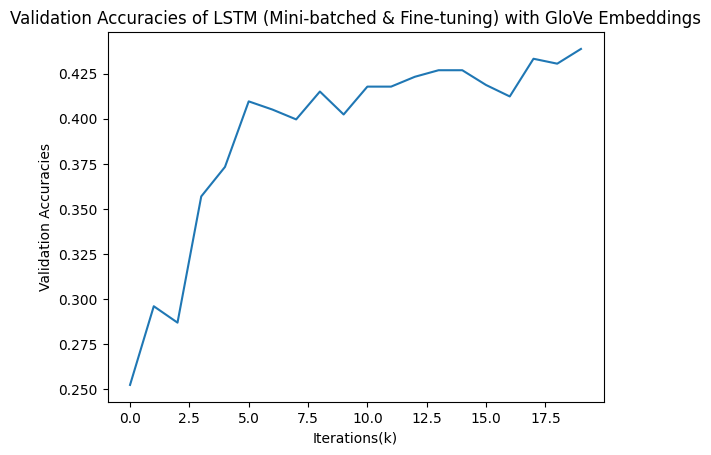

In [ ]:
# plot validation accuracy
plt.plot(lstm_mb_fine_accuracies)
plt.xlabel('Iterations(k)')
plt.ylabel('Validation Accuracies')
plt.title('Validation Accuracies of LSTM (Mini-batched & Fine-tuning) with GloVe Embeddings');


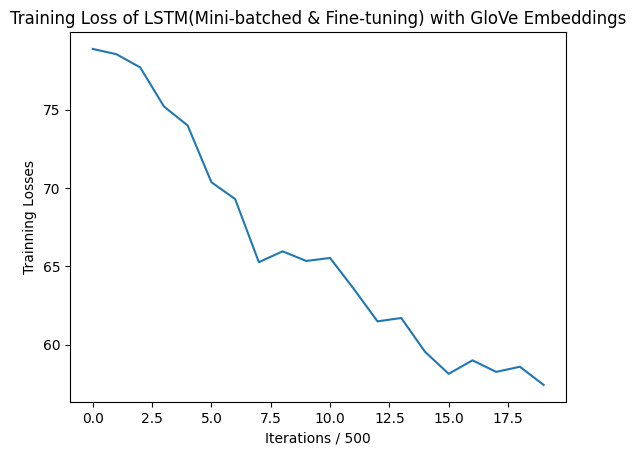

In [ ]:
# plot training loss
plt.plot(lstm_mb_fine_losses)
plt.xlabel('Iterations / 500')
plt.ylabel('Trainning Losses')
plt.title('Training Loss of LSTM(Mini-batched & Fine-tuning) with GloVe Embeddings');

>According to the plotted graphs, the model's convergence to its optimal state at around 950th iteration. Hence, we will set the number of iterations to 1000 when testing the model across three different random seeds.

In [ ]:
# Test Accuracies across 3 runs with different random seed

seeds = [10,42,50]
test_accs = []
batch_size = 25

sentences_lstm_tuned = []
aggregated_accuracies = defaultdict(list)

for seed in seeds:
  set_seed(seed)
  lstm_model = LSTMClassifier(len(v.w2i), 300, 168, len(t2i), v)
  # copy pre-trained word vectors into embeddings table
  with torch.no_grad():
    lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    lstm_model.embed.weight.requires_grad = True #word embedings update with the model
  lstm_model = lstm_model.to(device)
  optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)
  losses, accuracies, test_acc = train_model(
      lstm_model, optimizer, num_iterations=1000,
      print_every=50, eval_every=50, batch_size=batch_size,
      batch_fn=get_minibatch, prep_fn=prepare_minibatch, eval_fn=evaluate)
  test_accs.append(test_acc)

  _, _, _, batch_accuracies = evaluate_sl(
            lstm_model, test_data,
            batch_fn=get_minibatch_sl, prep_fn=prepare_minibatch,
            batch_size=batch_size)

  # Aggregate the batch accuracies
  for mean_length, accuracy in batch_accuracies.items():
    aggregated_accuracies[mean_length].append(accuracy)

# Calculate the mean and standard deviation of accuracies across seeds
mean_sentences_lstm_tuned = {length: np.mean(accs) for length, accs in aggregated_accuracies.items()}
std_dev_sentences_lstm_tuned = {length: np.std(accs) for length, accs in aggregated_accuracies.items()}

mean_acc = np.mean(test_accs)
std_dev = np.std(test_accs)
print('Test Accuracy of LSTM(Mini-batched & Fine-tuning) with GloVe Embeddings:')
print("Test Accuracies: " + ", ".join(["{:.4f}".format(acc) for acc in test_accs]))
print("Mean accuracy={:.4f}, Standard Deviation={:.4f}".format(mean_acc, std_dev))


Shuffling training data
Iter 50: loss=79.0123, time=4.75s
iter 50: dev acc=0.2598
new highscore
Iter 100: loss=78.1177, time=8.53s
iter 100: dev acc=0.3215
new highscore
Iter 150: loss=77.7019, time=12.31s
iter 150: dev acc=0.2970
Iter 200: loss=76.8427, time=15.83s
iter 200: dev acc=0.3579
new highscore
Iter 250: loss=72.8655, time=19.63s
iter 250: dev acc=0.3669
new highscore
Iter 300: loss=69.5766, time=23.35s
iter 300: dev acc=0.3924
new highscore
Shuffling training data
Iter 350: loss=69.1580, time=28.43s
iter 350: dev acc=0.3860
Iter 400: loss=65.6721, time=32.14s
iter 400: dev acc=0.4133
new highscore
Iter 450: loss=64.3346, time=36.79s
iter 450: dev acc=0.4069
Iter 500: loss=65.6404, time=40.41s
iter 500: dev acc=0.4178
new highscore
Iter 550: loss=65.6096, time=44.11s
iter 550: dev acc=0.4178
Iter 600: loss=63.3572, time=47.61s
iter 600: dev acc=0.4124
Iter 650: loss=63.5186, time=51.00s
iter 650: dev acc=0.4060
Shuffling training data
Iter 700: loss=60.7894, time=55.89s
iter 

# Tree-LSTM

In the final part of this project we will exploit the tree structure of the SST data.
Until now we only used the surface tokens, but remember that our data examples include binary trees with a sentiment score at every node.




## Computation

Do you remember the `transitions_from_treestring` function all the way in the beginning of this project? Every example contains a **transition sequence** produced by this function. Let's look at it again:



In [ ]:
ex = next(examplereader("trees/dev.txt"))
print(TreePrettyPrinter(ex.tree))
print("Transitions:")
print(ex.transitions)

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

<ipython-input-63-0d63b35e49bd>:2: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(ex.tree))


The tree is **binary**. Every node has two children, except for pre-terminal nodes.

A tree like this can be described by a sequence of **SHIFT (0)** and **REDUCE (1)** actions.

To construct a tree, we can use the transitions as follows:
- **reverse** the sentence (a list of tokens) and call this the **buffer**
   - the first word is now on top (last in the list), and we would get it when calling pop() on the buffer
- create an empty list and call it the **stack**
- iterate through the transition sequence:
  - if it says SHIFT(0), we pop a word from the buffer, and push it to the stack
  - if it says REDUCE(1), we pop the **top two items** from the stack, and combine them (e.g. with a Tree-LSTM!), creating a new node that we push back on the stack
  
Convince yourself that going through the transition sequence above will result in the tree that you see.
For example, we would start by putting the following words on the stack (by shifting 5 times, starting with `It`):

```
Top of the stack:
-----------------
film
lovely
a
's  
It
```
Now we find a REDUCE in the transition sequence, so we get the top two words (film and lovely), and combine them, so our new stack becomes:
```
Top of the stack:
-----------------
lovely film
a
's  
It
```

We will use this approach when encoding sentences with our Tree-LSTM.
Now, our sentence is a reversed list of word embeddings.
When we shift, we move a word embedding to the stack.
When we reduce, we apply the Tree-LSTM to the top two vectors, and the result is a single vector that we put back on the stack.
After going through the whole transition sequence, we will have the root node on our stack! We can use that to classify the sentence.



## Obtaining the transition sequence



So what goes on in the `transitions_from_treestring` function?

The idea ([explained in this blog post](https://devblogs.nvidia.com/recursive-neural-networks-pytorch/)) is that, if we had a tree, we could traverse through the tree, and every time that we find a node containing only a word, we output a SHIFT.
Every time **after** we have finished visiting the children of a node, we output a REDUCE.
(What is this tree traversal called?)

However, our `transitions_from_treestring` function operates directly on the string representation. It works as follows.

We start with the representation:

```
(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))
```

First we remove pre-terminal nodes (and add spaces before closing brackets):

```
(3 It (4 (4 's (4 (3 a (4 lovely film ) ) (3 with (4 (3 lovely performances ) (2 by (2 (2 Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove node projectels:

```
( It ( ( 's ( ( a ( lovely film ) ) ( with ( ( lovely performances) ( by ( ( Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove opening brackets:

```
It 's a lovely film ) ) with lovely performances ) by Buy and ) Accorsi ) ) ) ) ) ) . ) )
```

Now we replace words by S (for SHIFT), and closing brackets by R (for REDUCE):

```
S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1
```

Et voilà. We just obtained the transition sequence!

In [ ]:
# for comparison
seq = ex.transitions
s = " ".join(["S" if t == 0 else "R" for t in seq])
print(s)
print(" ".join(map(str, seq)))

S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1


## Coding the Tree-LSTM




In [ ]:
class TreeLSTMCell(nn.Module):
  """A Binary Tree LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    self.reduce_layer = nn.Linear(2 * hidden_size, 5 * hidden_size)
    self.dropout_layer = nn.Dropout(p=0.25)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, hx_l, hx_r, mask=None):
    """
    hx_l is ((batch, hidden_size), (batch, hidden_size))
    hx_r is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h_l, prev_c_l = hx_l  # left child
    prev_h_r, prev_c_r = hx_r  # right child

    B = prev_h_l.size(0)

    # we concatenate the left and right children
    # you can also project from them separately and then sum
    children = torch.cat([prev_h_l, prev_h_r], dim=1)

    # project the combined children into a 5D tensor for i,fl,fr,g,o
    # this is done for speed, and you could also do it separately
    proj = self.reduce_layer(children)  # shape: B x 5D

    # each shape: B x D
    i, f_l, f_r, g, o = torch.chunk(proj, 5, dim=-1)

    # main Tree LSTM computation


    # The shape of each of these is [batch_size, hidden_size]
    #projects the concatenation of the left and right child into the input gate, left forget gate, right forget gate, candidate, and output gate.
    i = torch.sigmoid(i)
    f_l = torch.sigmoid(f_l)
    f_r = torch.sigmoid(f_r)
    g = torch.tanh(g)
    o = torch.sigmoid(o)

    c = f_l * prev_c_l + f_r * prev_c_r + i * g
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

## Explanation of the TreeLSTM class


The code below contains the TreeLSTM class, which implements everything we need in order to encode a sentence from word embeddings. The calculations are the same as in the paper, implemented such that the class `TreeLSTMCell` above is as general as possible and only takes two children to reduce them into a parent.


**Initialize $\mathbf{h}$ and $\mathbf{c}$ outside of the cell for the leaves**

At the leaves of each tree the children nodes are **empty**, whereas in higher levels the nodes are binary tree nodes that *do* have a left and right child (but no input $x$). By initializing the leaf nodes outside of the cell class (`TreeLSTMCell`), we avoid if-else statements in the forward pass.

The `TreeLSTM` class (among other things) pre-calculates an initial $h$ and $c$ for every word in the sentence. Since the initial left and right child are 0, the only calculations we need to do are based on $x$, and we can drop the forget gate calculation (`prev_c_l` and `prev_c_r` are zero). The calculations we do in order to initalize $h$ and $c$ are then:

$$
c_1 =  W^{(u)}x_1 \\
o_1 = \sigma (W^{(i)}x_1) \\
h_1 = o_1 \odot \text{tanh}(c_1)$$
*NB: note that these equations are chosen as initializations of $c$ and $h$, other initializations are possible and might work equally well.*

**Sentence Representations**

All our leaf nodes are now initialized, so we can start processing the sentence in its tree form. Each sentence is represented by a buffer (initially a list with a concatenation of $[h_1, c_1]$ for every word in the reversed sentence), a stack (initially an empty list) and a transition sequence. To encode our sentence, we construct the tree from its transition sequence as explained earlier.

*A short example that constructs a tree:*

We loop over the time dimension of the batched transition sequences (i.e. row by row), which contain values of 0's, 1's and 2's (representing SHIFT, REDUCE and padding respectively). If we have a batch of size 2 where the first example has a transition sequence given by [0, 0, 1, 0, 0, 0, 1] and the second by [0, 0, 1, 0, 0, 1], our transition batch will be given by the following two-dimensional numpy array:

$$
\text{transitions} =
\begin{pmatrix}
0 & 0\\
0 & 0\\
1 & 1\\
0 & 0\\
0 & 0\\
0 & 1\\
1 & 2
\end{pmatrix}
$$
The inner loop (`for transition, buffer, stack in zip(t_batch, buffers, stacks)`) goes over each example in the batch and updates its buffer and stack. The nested loop for this example will then do roughy the following:

```
Time = 0:  t_batch = [0, 0], the inner loop performs 2 SHIFTs.

Time = 1:  t_batch = [0, 0], ".."

Time = 2:  t_batch = [1, 1], causing the inner loop to fill the list child_l and child_r for both examples in the batch. Now the statement if child_l will return True, triggering a REDUCE action to be performed by our Tree LSTM cell with a batch size of 2.

Time = 3:  t_batch = [0, 0], "..".

Time = 4:  t_batch = [0, 0], ".."

Time = 5:  t_batch = [0, 1], one SHIFT will be done and another REDUCE action will be performed by our Tree LSTM, this time of batch size 1.  

Time = 6:  t_batch = [1, 2], triggering another REDUCE action with batch size 1.
```
*NB: note that this was an artificial example for the purpose of demonstrating parts of the code, the transition sequences do not necessarily represent actual trees.*

**Batching and Unbatching**

Within the body of the outer loop over time, we use the functions for batching and unbatching.

*Batching*

Before passing two lists of children to the reduce layer (an instance of `TreeLSTMCell`), we batch the children as they are at this point a list of tensors of variable length based on how many REDUCE actions there are to perform at a certain time step across the batch (let's call the length `L`). To do an efficient forward pass we want to transform the list to a pair of tensors of shape `([L, D], [L, D])`, which the function `batch` achieves.

*Unbatching*

In the same line where we batched the children, we unbatch the output of the forward pass to become a list of states of length `L` again. We do this because we need to loop over each example's transition at the current time step and push the children that are reduced into a parent to the stack.

*The batch and unbatch functions let us switch between the "PyTorch world" (Tensors) and the Python world (easy to manipulate lists).*


In [ ]:


def batch(states):
  """
  Turns a list of states into a single tensor for fast processing.
  This function also chunks (splits) each state into a (h, c) pair"""
  return torch.cat(states, 0).chunk(2, 1)

def unbatch(state):
  """
  Turns a tensor back into a list of states.
  First, (h, c) are merged into a single state.
  Then the result is split into a list of sentences.
  """
  return torch.split(torch.cat(state, 1), 1, 0)

In [ ]:
class TreeLSTM(nn.Module):
  """Encodes a sentence using a TreeLSTMCell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.reduce = TreeLSTMCell(input_size, hidden_size)

    # project word to initial c
    self.proj_x = nn.Linear(input_size, hidden_size)
    self.proj_x_gate = nn.Linear(input_size, hidden_size)

    self.buffers_dropout = nn.Dropout(p=0.5)

  def forward(self, x, transitions):
    """
    WARNING: assuming x is reversed!
    :param x: word embeddings [B, T, E]
    :param transitions: [2T-1, B]
    :return: root states
    """

    B = x.size(0)  # batch size
    T = x.size(1)  # time

    # compute an initial c and h for each word
    # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
    # We do not handle input x in the TreeLSTMCell itself.
    buffers_c = self.proj_x(x)
    buffers_h = buffers_c.tanh()
    buffers_h_gate = self.proj_x_gate(x).sigmoid()
    buffers_h = buffers_h_gate * buffers_h

    # concatenate h and c for each word
    buffers = torch.cat([buffers_h, buffers_c], dim=-1)

    D = buffers.size(-1) // 2

    # we turn buffers into a list of stacks (1 stack for each sentence)
    # first we split buffers so that it is a list of sentences (length B)
    # then we split each sentence to be a list of word vectors
    buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
    buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

    # create B empty stacks
    stacks = [[] for _ in buffers]

    # t_batch holds 1 transition for each sentence
    for t_batch in transitions:

      child_l = []  # contains the left child for each sentence with reduce action
      child_r = []  # contains the corresponding right child

      # iterate over sentences in the batch
      # each has a transition t, a buffer and a stack
      for transition, buffer, stack in zip(t_batch, buffers, stacks):
        if transition == SHIFT:
          stack.append(buffer.pop())
        elif transition == REDUCE:
          assert len(stack) >= 2, \
            "Stack too small! Should not happen with valid transition sequences"
          child_r.append(stack.pop())  # right child is on top
          child_l.append(stack.pop())

      # if there are sentences with reduce transition, perform them batched
      if child_l:
        reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
        for transition, stack in zip(t_batch, stacks):
          if transition == REDUCE:
            stack.append(next(reduced))

    final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
    final = torch.cat(final, dim=0)  # tensor [B, D]

    return final

Just like the LSTM before, we will need an extra class that does the classifications.

In [ ]:
class TreeLSTMClassifier(nn.Module):
  """Encodes sentence with a TreeLSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(TreeLSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.treelstm = TreeLSTM(embedding_dim, hidden_dim)
    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(hidden_dim, output_dim, bias=True)
    )

  def forward(self, x):

    # x is a pair here of words and transitions; we unpack it here.
    # x is batch-major: [B, T], transitions is time major [2T-1, B]
    x, transitions = x
    emb = self.embed(x)

    # we use the root/top state of the Tree LSTM to classify the sentence
    root_states = self.treelstm(emb, transitions)

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(root_states)
    return logits

## Special `prepare` function for Tree-LSTM

We need yet another `prepare` function. For our implementation, sentences need to be *reversed*. We will do that here.

In [ ]:
def prepare_treelstm_minibatch(mb, vocab):
  """
  Returns sentences reversed (last word first)
  Returns transitions together with the sentences.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  # NOTE: reversed sequence!
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen)[::-1] for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  maxlen_t = max([len(ex.transitions) for ex in mb])
  transitions = [pad(ex.transitions, maxlen_t, pad_value=2) for ex in mb]
  transitions = np.array(transitions)
  transitions = transitions.T  # time-major

  return (x, transitions), y

## Training

In [ ]:
def do_train(model, num_iterations = 6000):

  print(model)
  print_parameters(model)

  model = model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=2e-4)

  return train_model(
      model, optimizer, num_iterations=num_iterations,
      print_every=250, eval_every=250,
      prep_fn=prepare_treelstm_minibatch,
      eval_fn=evaluate,
      batch_fn=get_minibatch,
      batch_size=25, eval_batch_size=25)


In [ ]:
print(len(train_data))

8544


In [ ]:
# Now let's train the Tree LSTM!

tree_model = TreeLSTMClassifier(
    len(v.w2i), 300, 150, len(t2i), v)

with torch.no_grad():
  tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  tree_model.embed.weight.requires_grad = False


results = do_train(tree_model, num_iterations=15000)

TreeLSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (treelstm): TreeLSTM(
    (reduce): TreeLSTMCell(300, 150)
    (proj_x): Linear(in_features=300, out_features=150, bias=True)
    (proj_x_gate): Linear(in_features=300, out_features=150, bias=True)
    (buffers_dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=150, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=False
treelstm.reduce.reduce_layer.weight [750, 300]   requires_grad=True
treelstm.reduce.reduce_layer.bias [750]        requires_grad=True
treelstm.proj_x.weight   [150, 300]   requires_grad=True
treelstm.proj_x.bias     [150]        requires_grad=True
treelstm.proj_x_gate.weight [150, 300]   requires_grad=True
treelstm.proj_x_gate.bias [150]        requires_grad=True
output_layer.1.weight    [5, 150]     requires_grad=True
output_layer.1.bias      [5]          requires_grad=True

T

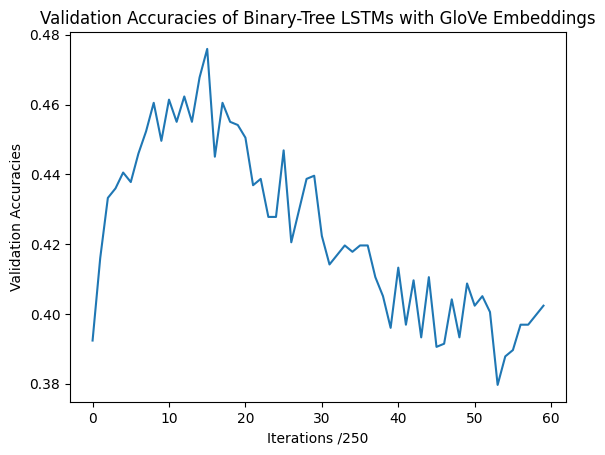

In [ ]:
# plot validation accuracy
plt.plot(results[1])
plt.xlabel('Iterations /250')
plt.ylabel('Validation Accuracies')
plt.title('Validation Accuracies of Binary-Tree LSTMs with GloVe Embeddings');

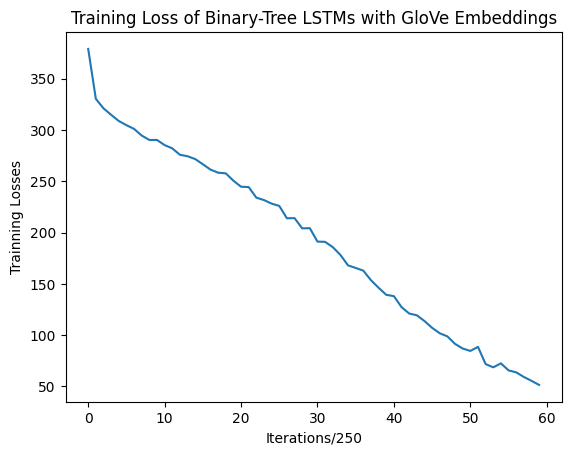

In [ ]:
# plot training loss
plt.plot(results[0])
plt.xlabel('Iterations/250')
plt.ylabel('Trainning Losses')
plt.title('Training Loss of Binary-Tree LSTMs with GloVe Embeddings');

## Testing

>According to the plotted graphs, the model's convergence to its optimal state at around 5500th iteration. Hence, we will set the number of iterations to 6000 when testing the model across three different random seeds.

In [ ]:
print(len(train_data))

8544


In [ ]:
# Test Accuracies across 3 runs with different random seed
seeds = [10,42,50]
test_accs = []
batch_size = 25

sentences_tree = []
aggregated_accuracies = defaultdict(list)

for seed in seeds:
  set_seed(seed)
  tree_model = TreeLSTMClassifier(len(v.w2i), 300, 150, len(t2i), v)
  # copy pre-trained word vectors into embeddings table
  with torch.no_grad():
    tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    tree_model.embed.weight.requires_grad = False
  results = do_train(tree_model, num_iterations=6000)
  test_accs.append(results[2])

  _, _, _, batch_accuracies = evaluate_sl(
            tree_model, test_data,
            batch_fn=get_minibatch_sl, prep_fn=prepare_treelstm_minibatch,
            batch_size=batch_size)

  # Aggregate the batch accuracies
  for mean_length, accuracy in batch_accuracies.items():
    aggregated_accuracies[mean_length].append(accuracy)

# Calculate the mean and standard deviation of accuracies across seeds
mean_sentences_tree = {length: np.mean(accs) for length, accs in aggregated_accuracies.items()}
std_dev_sentences_tree = {length: np.std(accs) for length, accs in aggregated_accuracies.items()}

mean_acc = np.mean(test_accs)
std_dev = np.std(test_accs)
print('Test Accuracy of Binary-Tree LSTMs with GloVe Embeddings:')
print("Test Accuracies: " + ", ".join(["{:.4f}".format(acc) for acc in test_accs]))
print("Mean accuracy={:.4f}, Standard Deviation={:.4f}".format(mean_acc, std_dev))








TreeLSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (treelstm): TreeLSTM(
    (reduce): TreeLSTMCell(300, 150)
    (proj_x): Linear(in_features=300, out_features=150, bias=True)
    (proj_x_gate): Linear(in_features=300, out_features=150, bias=True)
    (buffers_dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=150, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=False
treelstm.reduce.reduce_layer.weight [750, 300]   requires_grad=True
treelstm.reduce.reduce_layer.bias [750]        requires_grad=True
treelstm.proj_x.weight   [150, 300]   requires_grad=True
treelstm.proj_x.bias     [150]        requires_grad=True
treelstm.proj_x_gate.weight [150, 300]   requires_grad=True
treelstm.proj_x_gate.bias [150]        requires_grad=True
output_layer.1.weight    [5, 150]     requires_grad=True
output_layer.1.bias      [5]          requires_grad=True

T

# Further experiments

## Supervise sentiment at each node in the tree

In [ ]:
print(len(train_data))
print(train_data[0])

8544
Example(tokens=['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], tree=Tree('3', [Tree('2', [Tree('2', ['The']), Tree('2', ['Rock'])]), Tree('4', [Tree('3', [Tree('2', ['is']), Tree('4', [Tree('2', ['destined']), Tree('2', [Tree('2', [Tree('2', [Tree('2', [Tree('2', ['to']), Tree('2', [Tree('2', ['be']), Tree('2', [Tree('2', ['the']), Tree('2', [Tree('2', ['21st']), Tree('2', [Tree('2', [Tree('2', ['Century']), Tree('2', ["'s"])]), Tree('2', [Tree('3', ['new']), Tree('2', [Tree('2', ['``']), Tree('2', ['Conan'])])])])])])])]), Tree('2', ["''"])]), Tree('2', ['and'])]), Tree('3', [Tree('2', ['that']), Tree('3', [Tree('2', ['he']), Tree('3', [Tree('2', ["'s"]), Tree('3', [Tree('2', ['going']), Tree('3', [Tree('2', ['to']), Tree('4', [Tree('3', [T

In [ ]:
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])

def subtree(train_data):
  for i in train_data:
    tree = i.tree
    tree_pos = tree.treepositions()
    for position in tree_pos:
      subtree = tree[position]
      if type(subtree) is str:
        continue
      treesentence = subtree._pformat_flat("", "()", False)
      tokens = tokens_from_treestring(treesentence)
      label = int(treesentence[1])
      transition = transitions_from_treestring(treesentence)
      yield Example(tokens=tokens, tree=subtree, label=label, transitions=transition)

train_data = list(subtree(train_data))
print(len(train_data))

318582


In [ ]:
# Test Accuracies across 3 runs with different random seed
seeds = [10,42,50]
test_accs = []
batch_size = 25

sentences_tree = []
aggregated_accuracies = defaultdict(list)

for seed in seeds:
  set_seed(seed)
  tree_model = TreeLSTMClassifier(len(v.w2i), 300, 150, len(t2i), v)
  # copy pre-trained word vectors into embeddings table
  with torch.no_grad():
    tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    tree_model.embed.weight.requires_grad = False
  results = do_train(tree_model, num_iterations=15000)
  test_accs.append(results[2])

  _, _, _, batch_accuracies = evaluate_sl(
            tree_model, test_data,
            batch_fn=get_minibatch_sl, prep_fn=prepare_treelstm_minibatch,
            batch_size=batch_size)

  # Aggregate the batch accuracies
  for mean_length, accuracy in batch_accuracies.items():
    aggregated_accuracies[mean_length].append(accuracy)

# Calculate the mean and standard deviation of accuracies across seeds
mean_sentences_tree_subtree = {length: np.mean(accs) for length, accs in aggregated_accuracies.items()}
std_dev_sentences_tree_subtree = {length: np.std(accs) for length, accs in aggregated_accuracies.items()}

mean_acc = np.mean(test_accs)
std_dev = np.std(test_accs)
print('Test Accuracy of Binary-Tree LSTMs with GloVe Embeddings:')
print("Test Accuracies: " + ", ".join(["{:.4f}".format(acc) for acc in test_accs]))
print("Mean accuracy={:.4f}, Standard Deviation={:.4f}".format(mean_acc, std_dev))

TreeLSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (treelstm): TreeLSTM(
    (reduce): TreeLSTMCell(300, 150)
    (proj_x): Linear(in_features=300, out_features=150, bias=True)
    (proj_x_gate): Linear(in_features=300, out_features=150, bias=True)
    (buffers_dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=150, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=False
treelstm.reduce.reduce_layer.weight [750, 300]   requires_grad=True
treelstm.reduce.reduce_layer.bias [750]        requires_grad=True
treelstm.proj_x.weight   [150, 300]   requires_grad=True
treelstm.proj_x.bias     [150]        requires_grad=True
treelstm.proj_x_gate.weight [150, 300]   requires_grad=True
treelstm.proj_x_gate.bias [150]        requires_grad=True
output_layer.1.weight    [5, 150]     requires_grad=True
output_layer.1.bias      [5]          requires_grad=True

T

In [ ]:
LOWER = False  # we will keep the original casing
train_data = list(examplereader("trees/train.txt", lower=LOWER))

## Child-Sum Tree-LSTMs

In [ ]:
class ChildSum_TreeLSTMCell(nn.Module):
  """A Child-SUM Tree LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(ChildSum_TreeLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    self.reduce_layer = nn.Linear(2 * hidden_size, 2 * hidden_size) #forgate gates
    self.reduce_layer_sum = nn.Linear(hidden_size, 3 * hidden_size) #input gate, candidate gate, output gate
    self.dropout_layer = nn.Dropout(p=0.25)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, hx_l, hx_r, mask=None):
    """
    hx_l is ((batch, hidden_size), (batch, hidden_size))
    hx_r is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h_l, prev_c_l = hx_l  # left child
    prev_h_r, prev_c_r = hx_r  # right child

    B = prev_h_l.size(0)

    # concatenate the left and right children
    # sum the the left and right children
    children = torch.cat([prev_h_l, prev_h_r], dim=1)
    children_sum = torch.add(prev_h_l, prev_h_r)

    # project the combined children into a 3D tensor for i,g,o
    proj1 = self.reduce_layer_sum(children_sum)
    # project the combined children into a 2D tensor for fl,fr
    proj2 = self.reduce_layer(children)


    # each shape: B x D
    i, g, o = torch.chunk(proj1, 3, dim=-1)
    f_l, f_r = torch.chunk(proj2, 2, dim=-1)

    # main Child-Sum Tree LSTM computation

    # The shape of each of these is [batch_size, hidden_size]
    i = torch.sigmoid(i)
    f_l = torch.sigmoid(f_l)
    f_r = torch.sigmoid(f_r)
    g = torch.tanh(g)
    o = torch.sigmoid(o)

    c = f_l * prev_c_l + f_r * prev_c_r + i * g
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

In [ ]:
class ChildSum_TreeLSTM(nn.Module):
  """Encodes a sentence using a Child-Sum Tree-LSTMs"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(ChildSum_TreeLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.reduce = ChildSum_TreeLSTMCell(input_size, hidden_size)

    # project word to initial c
    self.proj_x = nn.Linear(input_size, hidden_size)
    self.proj_x_gate = nn.Linear(input_size, hidden_size)

    self.buffers_dropout = nn.Dropout(p=0.5)

  def forward(self, x, transitions):
    """
    WARNING: assuming x is reversed!
    :param x: word embeddings [B, T, E]
    :param transitions: [2T-1, B]
    :return: root states
    """

    B = x.size(0)  # batch size
    T = x.size(1)  # time

    # compute an initial c and h for each word
    # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
    # We do not handle input x in the TreeLSTMCell itself.
    buffers_c = self.proj_x(x)
    buffers_h = buffers_c.tanh()
    buffers_h_gate = self.proj_x_gate(x).sigmoid()
    buffers_h = buffers_h_gate * buffers_h

    # concatenate h and c for each word
    buffers = torch.cat([buffers_h, buffers_c], dim=-1)

    D = buffers.size(-1) // 2

    # we turn buffers into a list of stacks (1 stack for each sentence)
    # first we split buffers so that it is a list of sentences (length B)
    # then we split each sentence to be a list of word vectors
    buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
    buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

    # create B empty stacks
    stacks = [[] for _ in buffers]

    # t_batch holds 1 transition for each sentence
    for t_batch in transitions:

      child_l = []  # contains the left child for each sentence with reduce action
      child_r = []  # contains the corresponding right child

      # iterate over sentences in the batch
      # each has a transition t, a buffer and a stack
      for transition, buffer, stack in zip(t_batch, buffers, stacks):
        if transition == SHIFT:
          stack.append(buffer.pop())
        elif transition == REDUCE:
          assert len(stack) >= 2, \
            "Stack too small! Should not happen with valid transition sequences"
          child_r.append(stack.pop())  # right child is on top
          child_l.append(stack.pop())

      # if there are sentences with reduce transition, perform them batched
      if child_l:
        reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
        for transition, stack in zip(t_batch, stacks):
          if transition == REDUCE:
            stack.append(next(reduced))

    final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
    final = torch.cat(final, dim=0)  # tensor [B, D]

    return final

In [ ]:
class ChildSum_TreeLSTMClassifier(nn.Module):
  """Encodes sentence with a Child-Sum Tree-LSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(ChildSum_TreeLSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.treelstm = ChildSum_TreeLSTM(embedding_dim, hidden_dim)
    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(hidden_dim, output_dim, bias=True)
    )

  def forward(self, x):

    # x is a pair here of words and transitions; we unpack it here.
    # x is batch-major: [B, T], transitions is time major [2T-1, B]
    x, transitions = x
    emb = self.embed(x)

    # we use the root/top state of the Tree LSTM to classify the sentence
    root_states = self.treelstm(emb, transitions)

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(root_states)
    return logits

### Training

In [ ]:
# Train the Child-Sum Tree-LSTMs

child_sum_model = ChildSum_TreeLSTMClassifier(
    len(v.w2i), 300, 150, len(t2i), v)

with torch.no_grad():
  child_sum_model.embed.weight.data.copy_(torch.from_numpy(vectors))
  child_sum_model.embed.weight.requires_grad = False

def do_train(model):

  print(model)
  print_parameters(model)

  model = model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=2e-4)

  return train_model(
      model, optimizer, num_iterations=10000,
      print_every=250, eval_every=250,
      prep_fn=prepare_treelstm_minibatch,
      eval_fn=evaluate,
      batch_fn=get_minibatch,
      batch_size=25, eval_batch_size=25)

results = do_train(child_sum_model)

ChildSum_TreeLSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (treelstm): ChildSum_TreeLSTM(
    (reduce): ChildSum_TreeLSTMCell(300, 150)
    (proj_x): Linear(in_features=300, out_features=150, bias=True)
    (proj_x_gate): Linear(in_features=300, out_features=150, bias=True)
    (buffers_dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=150, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=False
treelstm.reduce.reduce_layer.weight [300, 300]   requires_grad=True
treelstm.reduce.reduce_layer.bias [300]        requires_grad=True
treelstm.reduce.reduce_layer_sum.weight [450, 150]   requires_grad=True
treelstm.reduce.reduce_layer_sum.bias [450]        requires_grad=True
treelstm.proj_x.weight   [150, 300]   requires_grad=True
treelstm.proj_x.bias     [150]        requires_grad=True
treelstm.proj_x_gate.weight [150, 300]   requires_grad=True
treel

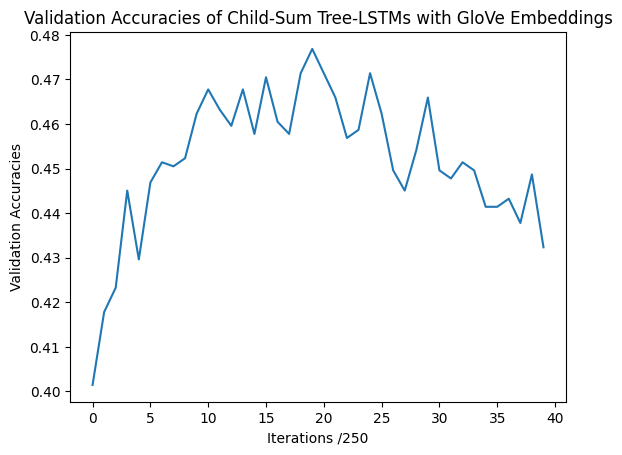

In [ ]:
# plot validation accuracy
plt.plot(results[1])
plt.xlabel('Iterations /250')
plt.ylabel('Validation Accuracies')
plt.title('Validation Accuracies of Child-Sum Tree-LSTMs with GloVe Embeddings');

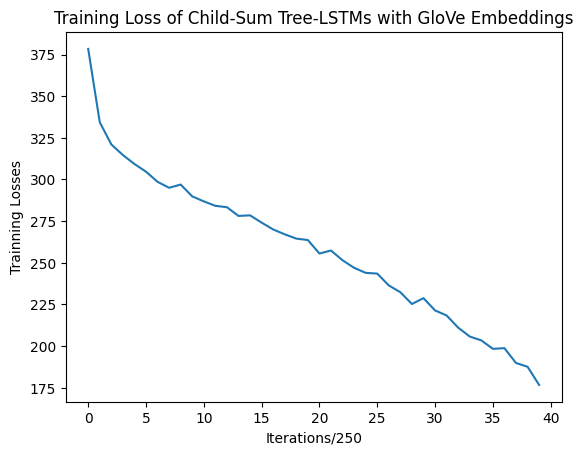

In [ ]:
# plot training loss
plt.plot(results[0])
plt.xlabel('Iterations/250')
plt.ylabel('Trainning Losses')
plt.title('Training Loss of Child-Sum Tree-LSTMs with GloVe Embeddings');

### Testing

In [ ]:
# Test Accuracies across 3 runs with different random seed
seeds = [10,42,50]
test_accs = []

batch_size = 25

sentences_childsum_tree = []
aggregated_accuracies = defaultdict(list)

for seed in seeds:
  set_seed(seed)
  child_sum_model = ChildSum_TreeLSTMClassifier(len(v.w2i), 300, 150, len(t2i), v)
  # copy pre-trained word vectors into embeddings table
  with torch.no_grad():
    child_sum_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    child_sum_model.embed.weight.requires_grad = False
  results = do_train(child_sum_model, num_iterations=10000)
  test_accs.append(results[2])

  _, _, _, batch_accuracies = evaluate_sl(
            child_sum_model, test_data,
            batch_fn=get_minibatch_sl, prep_fn=prepare_treelstm_minibatch,
            batch_size=batch_size)

  # Aggregate the batch accuracies
  for mean_length, accuracy in batch_accuracies.items():
    aggregated_accuracies[mean_length].append(accuracy)

# Calculate the mean and standard deviation of accuracies across seeds
mean_sentences_childsum_tree = {length: np.mean(accs) for length, accs in aggregated_accuracies.items()}
std_dev_sentences_childsum_tree = {length: np.std(accs) for length, accs in aggregated_accuracies.items()}

mean_acc = np.mean(test_accs)
std_dev = np.std(test_accs)
print('Test Accuracy of Child-Sum Tree-LSTMs with GloVe Embeddings:')
print("Test Accuracies: " + ", ".join(["{:.4f}".format(acc) for acc in test_accs]))
print("Mean accuracy={:.4f}, Standard Deviation={:.4f}".format(mean_acc, std_dev))


ChildSum_TreeLSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (treelstm): ChildSum_TreeLSTM(
    (reduce): ChildSum_TreeLSTMCell(300, 150)
    (proj_x): Linear(in_features=300, out_features=150, bias=True)
    (proj_x_gate): Linear(in_features=300, out_features=150, bias=True)
    (buffers_dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=150, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=False
treelstm.reduce.reduce_layer.weight [300, 300]   requires_grad=True
treelstm.reduce.reduce_layer.bias [300]        requires_grad=True
treelstm.reduce.reduce_layer_sum.weight [450, 150]   requires_grad=True
treelstm.reduce.reduce_layer_sum.bias [450]        requires_grad=True
treelstm.proj_x.weight   [150, 300]   requires_grad=True
treelstm.proj_x.bias     [150]        requires_grad=True
treelstm.proj_x_gate.weight [150, 300]   requires_grad=True
treel

## Sentence Length

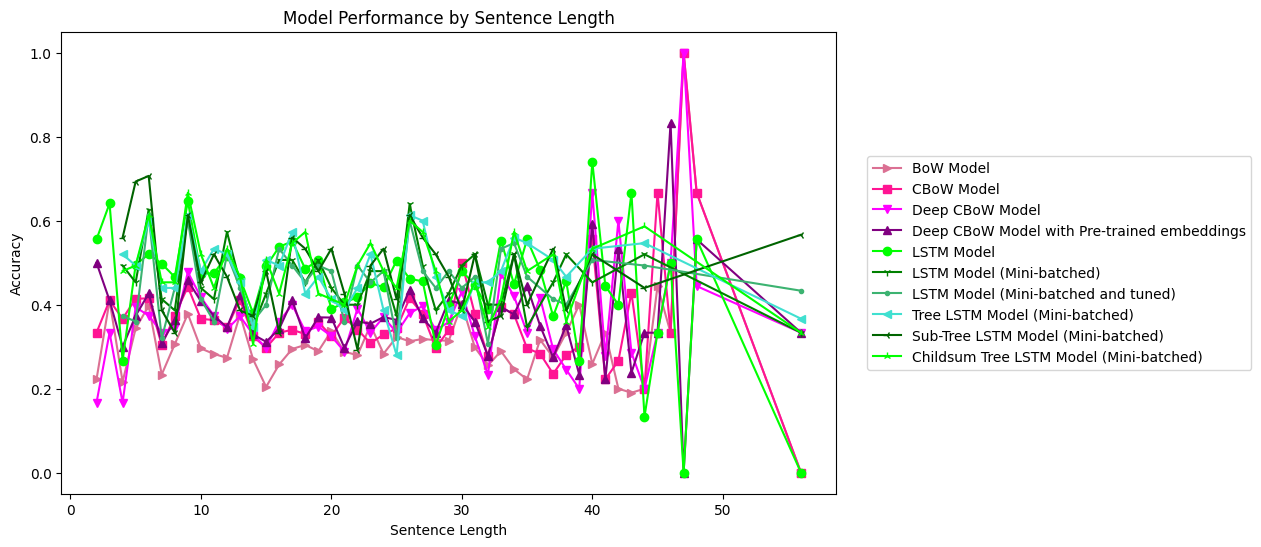

In [ ]:
bow_lengths = sorted(mean_sentences_bow.keys())
bow_accuracies = [mean_sentences_bow[length]['accuracy'] for length in bow_lengths]

cbow_lengths = sorted(mean_sentences_cbow.keys())
cbow_accuracies = [mean_sentences_cbow[length]['accuracy'] for length in cbow_lengths]

dcbow_lengths = sorted(mean_sentences_dcbow.keys())
dcbow_accuracies = [mean_sentences_dcbow[length]['accuracy'] for length in dcbow_lengths]

dcbow_pt_lengths = sorted(mean_sentences_dcbow_pt.keys())
dcbow_pt_accuracies = [mean_sentences_dcbow_pt[length]['accuracy'] for length in dcbow_pt_lengths]

lstm_lengths = sorted(mean_sentences_lstm.keys())
lstm_accuracies = [mean_sentences_lstm[length]['accuracy'] for length in lstm_lengths]

lstm_mb_lengths = sorted(mean_sentences_lstm_mb.keys())
lstm_mb_accuracies = [mean_sentences_lstm_mb[length] for length in lstm_mb_lengths]

lstm_tuned_lengths = sorted(mean_sentences_lstm_tuned.keys())
lstm_tuned_accuracies = [mean_sentences_lstm_tuned[length] for length in lstm_mb_lengths]

tree_lengths = sorted(mean_sentences_tree.keys())
tree_accuracies = [mean_sentences_tree[length] for length in tree_lengths]

subtree_lengths = sorted(mean_sentences_tree_subtree.keys())
subtree_accuracies = [mean_sentences_tree_subtree[length] for length in subtree_lengths]

childsum_tree_lengths = sorted(mean_sentences_childsum_tree.keys())
childsum_tree_accuracies = [mean_sentences_childsum_tree[length] for length in childsum_tree_lengths]



# Plotting
plt.figure(figsize=(10, 6))

plt.plot(bow_lengths, bow_accuracies, label='BoW Model', marker='>', color = 'palevioletred')
plt.plot(cbow_lengths, cbow_accuracies, label='CBoW Model', marker='s', color = 'deeppink')
plt.plot(dcbow_lengths, dcbow_accuracies, label='Deep CBoW Model', marker='v', color = 'magenta')
plt.plot(dcbow_pt_lengths, dcbow_pt_accuracies, label='Deep CBoW Model with Pre-trained embeddings', marker='^', color = 'purple')
plt.plot(lstm_lengths, lstm_accuracies, label='LSTM Model', marker='o', color = 'lime')
plt.plot(lstm_mb_lengths, lstm_mb_accuracies, label='LSTM Model (Mini-batched)', marker='1', color = 'green')
plt.plot(lstm_tuned_lengths, lstm_tuned_accuracies, label='LSTM Model (Mini-batched and tuned)', marker='.', color = 'mediumseagreen')
plt.plot(tree_lengths, tree_accuracies, label='Tree LSTM Model (Mini-batched)', marker='<', color = 'turquoise')
plt.plot(subtree_lengths, subtree_accuracies, label='Sub-Tree LSTM Model (Mini-batched)', marker='3', color = 'darkgreen')
plt.plot(childsum_tree_lengths, childsum_tree_accuracies, label='Childsum Tree LSTM Model (Mini-batched)', marker='2', color = 'lime')

plt.title('Model Performance by Sentence Length')
plt.xlabel('Sentence Length')
plt.ylabel('Accuracy')
# plt.legend()
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

# plt.grid(True)

plt.show()